# 1.Proje Özeti 

### 1.1 VinDr-Mammo Veri Setinin Özeti ve BI-RADS Kategorileri
VinDr-Mammo, dijital mamografi görüntüleme için geliştirilen ve lezyon seviyesinde kapsamlı açıklamalara sahip bir veri setidir. BI-RADS kategorileri, meme görüntüleme sonuçlarının değerlendirilmesinde standartlaştırılmış bir sistemdir ve bu veri seti hem meme seviyesi değerlendirmeleri hem de yerel lezyon açıklamalarını içerir.

### 1.2 BI-RADS Kategorileri ve Lezyon Türleri
#### 1.2.1 BI-RADS Kategorisi Nedir?

BI-RADS (Breast Imaging Reporting and Data System), meme görüntüleme sonuçlarını sınıflandırmak için kullanılır.
Bu sistem, lezyonların muhtemel iyi huylu (benign) ya da kötü huylu (malignant) olup olmadığını değerlendirir ve şu kategorilere ayrılır:
* BI-RADS 1: Negatif
* BI-RADS 2: İyi huylu (Benign)
* BI-RADS 3: Muhtemelen iyi huylu
* BI-RADS 4: Şüpheli
* BI-RADS 5: Kötü huylu olma olasılığı yüksek
  
### 1.3 Veri Setindeki Lezyon Türleri

#### 1.3.1 BI-RADS ile ilişkilendirilen lezyon türleri:
* Mass (Kitle)
* Suspicious Calcification (Şüpheli Kalsifikasyon)
* Architectural Distortion (Mimari Bozulma)
* Asymmetry (Asimetri)
#### 1.3.2 BI-RADS ile ilişkilendirilmeyen durumlar:
* Suspicious Lymph Node (Şüpheli Lenf Nodu)
* Skin Thickening (Cilt Kalınlaşması)
* Skin Retraction (Cilt Çekintisi)
* Nipple Retraction (Meme Ucu Çekintisi)
* No Finding (Hiçbir Bulgusu Yok)
 
#### Yerel Lezyonların Anotasyonu

Her lezyon, ilgili bir BI-RADS kategorisi ve bir bounding box (dikdörtgen alan) ile açıklanır.
Lezyon seviyesindeki açıklamalar, yalnızca BI-RADS 3 ve üzerindeki (şüpheli veya malign) kategorilere odaklanmıştır.

### 1.4 Veri Seti Yapısı ve Kullanımı
#### 1.4.1 finding_annotations.csv:

* Her lezyon için aşağıdaki bilgileri içerir:
image_id, study_id: Görüntü ve çalışma kimlikleri.
laterality, view_position: Görüntünün sağ/sol meme ve açı bilgisi.
bounding box koordinatları (xmin, ymin, xmax, ymax)

#### 1.4.2 breast-level_annotations.csv:

* Meme seviyesi bilgileri içerir:
breast_birads: Meme değerlendirme kategorisi.
breast_density: Meme yoğunluğu (A, B, C, D).


### 1.5 Meme Seviyesinin Bulgular Üzerindeki Etkisi
* Meme seviyesi değerlendirmesi, bir memede görülen bulguların genel bir özetidir. Bulgular genelde şu şekilde meme seviyesine bağlanır:

* Eğer memede şüpheli veya kötü huylu bulgular varsa (örneğin: Mass, Calcification), bu durum genellikle meme seviyesi BI-RADS kategorisini etkiler.
Örneğin:
* BI-RADS 1 veya 2: Bulgular iyi huylu veya yoktur.
* BI-RADS 3: Bulgular iyi huylu olabilir, ancak takip gerektirir.
* BI-RADS 4 veya 5: Bulgular şüpheli veya kötü huyludur.
### 1.5.1 Veri Setindeki Yapı
#### breast-level_annotations.csv:

Meme seviyesi bilgileri. Örneğin:
breast_birads: Meme için genel BI-RADS kategorisi.
breast_density: Meme yoğunluğu.
#### finding_annotations.csv:

Spesifik bulgular (Mass, Calcification gibi).
Her bulgu bir bounding box ile belirtilir ve meme seviyesiyle ilişkilendirilebilir.

# 2. GÖRÜNTÜLERİ DİCOM → JPG' E ÇEVİRMEK


## dicom_to_jpg.py

In [ ]:
import os
import zipfile
import numpy as np
import pydicom # python için dicom dönüştürme kütüphanesi
from PIL import Image
import cv2


def ensure_dir(directory):
    """Klasör varsa geç, yoksa oluştur."""
    if not os.path.exists(directory):
        os.makedirs(directory)


def apply_windowing(pixel_array, window_center, window_width):
    """
    Window level ve width'e göre piksel değerlerini ölçekler.
    """
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)

    # Piksel değerlerini pencereleme aralığına indirgeme
    pixel_array = np.clip(pixel_array, lower_bound, upper_bound)

    # Normalizasyon (0-255)
    normalized_array = ((pixel_array - lower_bound) / (upper_bound - lower_bound)) * 255
    return np.uint8(normalized_array)


def get_safe_dicom_value(value):
    """
    DICOM değerlerini işlemek için güvenli bir yöntem.
    MultiValue, DSfloat gibi özel durumları ele alır.
    """
    try:
        if isinstance(value, pydicom.multival.MultiValue):
            return float(value[0])  # İlk değeri kullan
        elif isinstance(value, (pydicom.valuerep.DSfloat, pydicom.valuerep.DSdecimal)):
            return float(value)
        return float(value)
    except Exception:
        return None  # Eğer değer okunamıyorsa None döndür


def dicom_to_jpg(dicom_file, output_path):
    """
    DICOM dosyasını JPG formatına dönüştürür.
    """
    try:
        # DICOM dosyasını oku
        ds = pydicom.dcmread(dicom_file)
        pixel_array = ds.pixel_array

        # Pencereleme merkezi ve genişliğini belirle
        window_center = get_safe_dicom_value(ds.get("WindowCenter"))
        window_width = get_safe_dicom_value(ds.get("WindowWidth"))

        # Eğer pencereleme bilgisi eksikse otomatik hesapla
        if window_center is None:
            window_center = (pixel_array.max() + pixel_array.min()) / 2
        if window_width is None:
            window_width = (pixel_array.max() - pixel_array.min())

        # Pencereleme uygula
        pixel_array = apply_windowing(pixel_array, window_center, window_width)

        # Görüntüyü JPG formatına dönüştür ve kaydet
        image = Image.fromarray(pixel_array)
        image = image.convert("L")  # Gri tonlama
        image.save(output_path, "JPEG", quality=95)
        print(f"Başarılı: {output_path}")
    except Exception as e:
        print(f"Hata ({output_path}): {e}")


def process_zip(zip_path, output_folder):
    """
    ZIP içerisindeki tüm DICOM dosyalarını JPG formatına dönüştürür.
    - zip_path: ZIP dosyasının yolu.
    - output_folder: Çıktı dosyalarının kaydedileceği klasör.
    """
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file_name in z.namelist():
            # Sadece DICOM dosyalarını işliyoruz
            if file_name.endswith(".dicom"):
                try:
                    # Çıktı dosyasının yolu
                    relative_path = os.path.splitext(file_name)[0]  # .dicom uzantısını çıkar
                    output_path = os.path.join(output_folder, relative_path + ".jpg")

                    # Çıktı klasör yapısını oluştur
                    ensure_dir(os.path.dirname(output_path))

                    # ZIP içerisindeki DICOM dosyasını okuyarak dönüştür
                    with z.open(file_name) as dicom_file:
                        dicom_to_jpg(dicom_file, output_path)
                except Exception as e:
                    print(f"Hata ({file_name}): {e}")
            else:
                # Diğer dosyaları olduğu gibi çıkart
                output_path = os.path.join(output_folder, file_name)
                ensure_dir(os.path.dirname(output_path))
                with z.open(file_name) as file:
                    with open(output_path, "wb") as out_file:
                        out_file.write(file.read())
                print(f"Diğer dosya taşındı: {output_path}")


# Ana çalışma fonksiyonu
if __name__ == "__main__":
    # Kullanıcı ayarları
    zip_file_path = r"C:\Users\Monster\Desktop\mammo_dataset.zip"  # ZIP dosyasının tam yolu
    output_directory = r"C:\Users\Monster\Desktop\mammo_dataset_output2"  # Çıktıların kaydedileceği klasör

    # Çıktı klasörünü oluştur
    ensure_dir(output_directory)

    # ZIP dosyasını işle
    process_zip(zip_file_path, output_directory)

    print("İşlem tamamlandı!")



# 3. GÖRÜNTÜLERİ AYIRMAK SPLİT İŞLEMİ

## images_split.py

In [ ]:
import os
import shutil
import pandas as pd

# CSV dosyasının yolu
csv_file_path = r"C:\Users\Monster\Desktop\finding_annotations.csv"

# Görüntülerin ana klasörünün yolu
images_directory = r"C:\Users\Monster\Desktop\images"

# Hedef klasörlerin ana yolu
target_base_directory = r"C:\Users\Monster\Desktop\organized_images"

# CSV dosyasını oku
data = pd.read_csv(csv_file_path)

# Training ve test klasörlerini oluştur
for split in ['training', 'test']:
    split_directory = os.path.join(target_base_directory, split)
    if not os.path.exists(split_directory):
        os.makedirs(split_directory)

# Görüntüleri taşı
for _, row in data.iterrows():
    folder_name = row['study_id']  # images ana klasöründeki alt klasör adı
    image_name = row['image_id']  # Alt klasör içindeki görüntü adı
    split = row['split']          # Training ya da test

    # Kaynak dosya yolu
    source_path = os.path.join(images_directory, folder_name, image_name + ".jpg")

    # Hedef dosya yolu
    target_path = os.path.join(target_base_directory, split, image_name + ".jpg")

    # Görüntü varsa taşı
    if os.path.exists(source_path):
        shutil.copy(source_path, target_path)
    else:
        print(f"Image not found: {source_path}")


# 4. ETİKETLERİ AYIRMAK SPLİT İŞLEMİ

## 4.1 CATEGORY MAPPİNG

* 0: Architectural Distortion → Mimari Bozulma
* 1: Asymmetry → Asimetri
* 2: Focal Asymmetry → Fokal Asimetri
* 3: Global Asymmetry → Global Asimetri
* 4: Mass → Kitle
* 5: Nipple Retraction → Meme Başı Çekintisi
* 6: No Finding → Bulgusuz
* 7: Skin Retraction → Cilt Çekintisi
* 8: Skin Thickening → Cilt Kalınlaşması
* 9: Suspicious Calcification → Şüpheli Kalsifikasyon
* 10: Suspicious Lymph Node → Şüpheli Lenf Nodu


## labels_split.py

In [ ]:
import os
import pandas as pd

# CSV dosyasının yolu
csv_file_path = r"C:\Users\Monster\Desktop\finding_annotations.csv"

# Hedef klasörlerin ana yolu
target_base_directory = r"C:\Users\Monster\Desktop\organized_labels"

# CSV dosyasını yükle
data = pd.read_csv(csv_file_path)

# Eksik bounding box verilerini filtrele
data = data.dropna(subset=['xmin', 'ymin', 'xmax', 'ymax'])
"""
yolo ile eğitim yapacağımızdan yolo format şekli:

class_id x_center y_center width height

"""
# 'finding_categories' sütununu listeye çevir
data['finding_categories'] = data['finding_categories'].apply(eval)

# Kategori encode
category_to_id = {
    "Architectural Distortion": 0,
    "Asymmetry": 1,
    "Focal Asymmetry": 2,
    "Global Asymmetry": 3,
    "Mass": 4,
    "Nipple Retraction": 5,
    "No Finding": 6, # bu sınıf zaten bulunmuyor
    "Skin Retraction": 7,
    "Skin Thickening": 8,
    "Suspicious Calcification": 9,
    "Suspicious Lymph Node": 10
}

# Hedef klasörleri oluştur
splits = data['split'].unique()
for split in splits:
    split_dir = os.path.join(target_base_directory, split)
    os.makedirs(split_dir, exist_ok=True)

# Etiket dosyalarını oluştur
def generate_yolo_labels(group):
    """
    Belirli bir image_id için YOLO formatında etiketleri döndürür.
    """
    image_height = group['height'].iloc[0]
    image_width = group['width'].iloc[0]
    labels = []

    for _, row in group.iterrows():
        for category in row['finding_categories']:
            if category in category_to_id:
                class_id = category_to_id[category]

                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

                # YOLO formatına dönüştürme
                x_center = ((xmin + xmax) / 2) / image_width
                y_center = ((ymin + ymax) / 2) / image_height
                bbox_width = (xmax - xmin) / image_width
                bbox_height = (ymax - ymin) / image_height

                 # YOLO formatı: class_id x_center y_center width height , yukarda da yazdığım gibi
                labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

    return labels

# Grupları işlemeye başla
grouped_data = data.groupby('image_id')
for image_id, group in grouped_data:
    split = group['split'].iloc[0]  # Split değerini al
    yolo_labels = generate_yolo_labels(group)

    if yolo_labels:  # Sadece etiket varsa dosya oluştur
        split_dir = os.path.join(target_base_directory, split)
        label_path = os.path.join(split_dir, f"{image_id}.txt")
        with open(label_path, 'w') as f:
            f.write("\n".join(yolo_labels))

# Kategori eşlemesini kaydet
category_mapping_path = os.path.join(target_base_directory, "category_mapping.txt")
with open(category_mapping_path, 'w') as f:
    for category, idx in category_to_id.items():
        f.write(f"{idx}: {category}\n")

print("Etiketleme ve dosya organizasyonu tamamlandı!")


# 4.2 ETİKETLERİ GÖRÜNTÜLER ÜZERİNDE GÖSTERMEK 

## show_labels_on_images.py

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Görüntü ve etiket dosyasının yolları
# image_path = r"C:\Users\Monster\Desktop\0a6f0eac805822cd00f3c25ba99569e8.jpg"
# label_path = r"C:\Users\Monster\Desktop\0a6f0eac805822cd00f3c25ba99569e8.txt"
# image_path = r"C:\Users\Monster\Desktop\00be38a5c0566291168fe381ba0028e6.jpg"
# label_path = r"C:\Users\Monster\Desktop\00be38a5c0566291168fe381ba0028e6.txt"
# "C:\Users\Monster\Desktop\b6d0903ba96ff1157a6b055bd56181d3.jpg"
# b6d0903ba96ff1157a6b055bd56181d3
# burada belli görüntüleri test ettim

image_path = r"C:\Users\Monster\Desktop\b6d0903ba96ff1157a6b055bd56181d3.jpg"
label_path = r"C:\Users\Monster\Desktop\b6d0903ba96ff1157a6b055bd56181d3.txt"

# Görüntüyü yükle
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Etiket dosyasını oku ve bounding box'ları çiz
image_height, image_width, _ = image.shape
with open(label_path, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Bounding box koordinatlarını çöz
        xmin = int((x_center - width / 2) * image_width)
        ymin = int((y_center - height / 2) * image_height)
        xmax = int((x_center + width / 2) * image_width)
        ymax = int((y_center + height / 2) * image_height)

        # Bounding box'u çiz
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2) # isteğe bağlı kırmızı çizdim

# Görüntüyü göster
plt.imshow(image)
plt.axis('off')
plt.show()


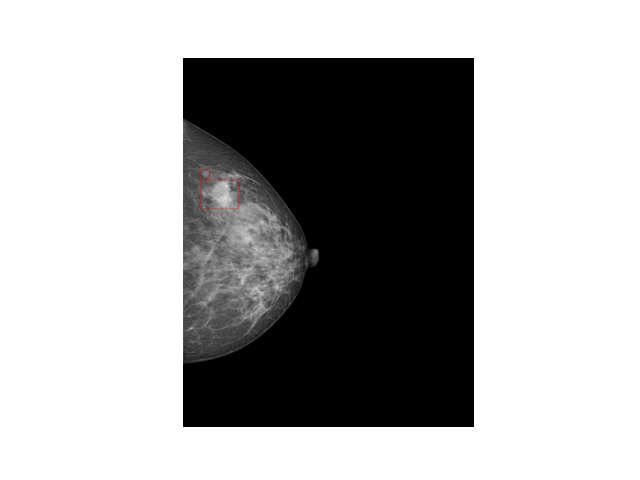

# 4.2 Etiketi Olan Görüntüleri Çekmek İçin:

## images_labels_matching.py

In [ ]:
import os
import shutil

# Klasör yolları
label_dirs = {
    "test": r"C:\Users\Monster\Desktop\organized_labels\test",
    "training": r"C:\Users\Monster\Desktop\organized_labels\training"
}

image_dirs = {
    "test": r"C:\Users\Monster\Desktop\organized_images2\test",
    "training": r"C:\Users\Monster\Desktop\organized_images2\training"
}

# Hedef klasörler (organize edilmiş dosyalar buraya kopyalanacak)
output_dirs = {
    "test": r"C:\Users\Monster\Desktop\imagee\test",
    "training": r"C:\Users\Monster\Desktop\imagee\training"
}

# İşlem
for category in label_dirs:
    label_path = label_dirs[category]
    image_path = image_dirs[category]
    output_path = output_dirs[category]

    # Klasörler varsa işlem yap
    if os.path.exists(label_path) and os.path.exists(image_path):
        # Etiket dosyalarını al
        label_files = {os.path.splitext(f)[0] for f in os.listdir(label_path) if f.endswith('.txt')}

        # Görüntü dosyalarını kontrol et
        for image_file in os.listdir(image_path):
            image_name, image_ext = os.path.splitext(image_file)
            if image_ext.lower() == ".jpg" and image_name in label_files:
                # Dosya eşleşirse hedef klasöre taşı veya kopyala
                src_image = os.path.join(image_path, image_file)
                dst_image = os.path.join(output_path, image_file)

                # Kopyalama işlemi
                shutil.copy(src_image, dst_image)
                print(f"Kopyalandı: {src_image} -> {dst_image}")
    else:
        print(f"{category} klasörlerinden biri eksik, işlem atlandı.")


# 4.3 HER SINIFTAN KAÇ TANE GÖRÜNTÜ VAR TRAİN İÇİN VE VAL İÇİN 

## class_names_numbers.py

In [ ]:
import os
from collections import Counter

# Etiketlerin encode edilmiş isimleri
label_names = {
    0: "Architectural Distortion",
    1: "Asymmetry",
    2: "Focal Asymmetry",
    3: "Global Asymmetry",
    4: "Mass",
    5: "Nipple Retraction",
    6: "No Finding",
    7: "Skin Retraction",
    8: "Skin Thickening",
    9: "Suspicious Calcification",
    10: "Suspicious Lymph Node",
}


# Verilen dizindeki TXT dosyalarını okuyup etiket sayısı çıkaran fonksiyon
def count_labels_in_directory(directory):
    label_counts = Counter()

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)

        # TXT dosyasını oku
        if filename.endswith(".txt"):
            with open(filepath, "r", encoding="utf-8") as f:
                for line in f:
                    # Sınıf numarası satırın ilk elemanıdır
                    parts = line.strip().split()  # Satırı parçala
                    if parts:  # Boş satır kontrolü
                        label_id = int(parts[0])  # İlk elemanı sınıf numarası olarak al
                        if label_id in label_names:
                            label_counts[label_id] += 1

    # İsimlere göre sonuçları düzenle
    return {label_names[label]: count for label, count in label_counts.items()}


# Eğitim ve doğrulama yolları
train_dir = r"C:\Users\Monster\Desktop\vindr_data\train\labels"
val_dir = r"C:\Users\Monster\Desktop\vindr_data\val\labels"

# Eğitim ve doğrulama verilerindeki etiket sayıları
train_label_counts = count_labels_in_directory(train_dir)
val_label_counts = count_labels_in_directory(val_dir)

# Sonuçları yazdır
print("Eğitim Verileri:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

print("\nDoğrulama Verileri:")
for label, count in val_label_counts.items():
    print(f"{label}: {count}")


## Eğitim Verileri:
* Mass: 989
* Suspicious Calcification: 428
* Focal Asymmetry: 216
* Architectural Distortion: 95
* Asymmetry: 77
* Skin Thickening: 45
* Suspicious Lymph Node: 46
* Nipple Retraction: 30
* Global Asymmetry: 20
* Skin Retraction: 15

## Doğrulama Verileri:
* Suspicious Calcification: 115
* Mass: 237
* Focal Asymmetry: 53
* Architectural Distortion: 24
* Suspicious Lymph Node: 11
* Asymmetry: 20
* Skin Thickening: 12
* Nipple Retraction: 7
* Global Asymmetry: 6
* Skin Retraction: 3


# 4.4 Eğitim Öncesinde Veri Seti Oluşturma Aşamasının Sonucu

* Verileri ayırırken "No Finding" sınıfının etiketleri olmadığı görülmüştür.
* Veri Setinin lezyon bulma kısımlarını içeren sınıflar içerisinde "No Finding" sınıfı veri setinde çok sayıda görüntüye sahiptir.
* Bu yüzden eğitim yaparken bounding box koordinatlarına erişim sağlanamış "No Finding" sınıfının görüntüleri kullanılmamıştır.
* Ayrıca diğer etiketi olan sınıflar içerisinde ki veri sayısı dengesizliği eğitimi kötü etkileyeceği öngörülmüştür.
* Veri seti içerisindeki veri sayılarının yakın değerlerde olması öğrenme oranınını artırmaktadır.
* Eğer meme yoğunluğuyla ilgili eğitim yapılması istenseydi her bir görüntü üzerinde segmentasyon işlemi yapılarak meme yoğunluğu tahmini yapılabilirdi.
  

# 5. EĞİTİM AŞAMASI

# 5.1 YOLO İÇİN CONFİG DOSYASI OLUŞTURULMASI

## config.yaml

In [ ]:
path: /content/drive/MyDrive/data/vindr_data # Veri seti Colab dizini

train: /content/drive/MyDrive/data/vindr_data/train/images # Bunlarda Colabtaki dizinler
val: /content/drive/MyDrive/data/vindr_data/val/images

# Veri Setindeki Sınıflar
names: [
    "Architectural Distortion",
    "Asymmetry",
    "Focal Asymmetry",
    "Global Asymmetry",
    "Mass",
    "Nipple Retraction",
    "No Finding",
    "Skin Retraction",
    "Skin Thickening",
    "Suspicious Calcification",
    "Suspicious Lymph Node"
]


# 5.2 BİRİNCİ EĞİTİM

* Eğitim Google Drive içerisindeki google colaboratory notebook ile yapılmıştır.
* Eğitim yaparken colab kullanım sınırı geçildiğinden fine tuning işlemleriyle eğitime devam edilmeye çalışılmıştır.
* Eğitimde YOLOv11-Large modeli kullanılmıştır imgsz → 640 , Batch → 8 , Workers → 8 , epochs → 10000 (verilmiştir ancak erişim sınırı yüzünden 118.epochta ilk eğitim sonlanmıştır.)
* Eğitim erişim sınırı yüzünden sonlandığı için eğitim sonuç görüntüleri oluşmamıştır , last.pt ve best.pt modelleri oluşmuştur.
  

### 5.2.1 Google Colaboratory Notebook

##### GOOGLE DRİVE'A BAĞLANMAK

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

##### İstenilen Dosya Dizinine Gitmek

In [ ]:
%cd /content/drive/MyDrive

##### Google Drive'a Zip Olarak Yüklediğimiz Veri Setimizi Ayrıştırmak

In [ ]:
!unzip /content/drive/MyDrive/vindr_data.zip -d ./data

##### Gerekli Kütüphaneyi Yüklemek Ve Kontrol Etmek

In [ ]:
%pip install ultralytics

import ultralytics
ultralytics.checks()

##### Eğitim Parametrelerini Ayarlayarak Eğtimi başlatmak

In [ ]:
!yolo detect train data=/content/drive/MyDrive/config.yaml model=yolo11l.pt epochs=1000 imgsz=640 workers=8  batch=8 device=0 name=trained_data

##### Fine-tuning ile devam ettiğim 2. Eğitim kodu

In [ ]:
!yolo detect train data=/content/drive/MyDrive/config.yaml model=/content/drive/MyDrive/last.pt epochs=75 imgsz=640 workers=8 batch=8 device=0 name=trained_data_resume

# 5.3 İKİNCİ EĞİTİM 

* Erişim problemi olduğundan (100 epoch kadar eğitim yapma izini varmış) 75 epoch tekrar kaldığı yerden last.pt kullanılarak eğitim devam edildi , bu model öğrenmesi için ve doğruluğu için çok iyi bir uygulama değil ancak eğitim sonuçlarına erişmek için bu yolu tercih ettim.

### 5.3.1 EĞİTİM SONUÇLARI VE SONUÇ GÖRSELLERİ

<div style="display: flex; justify-content: space-around; align-items: center;">
    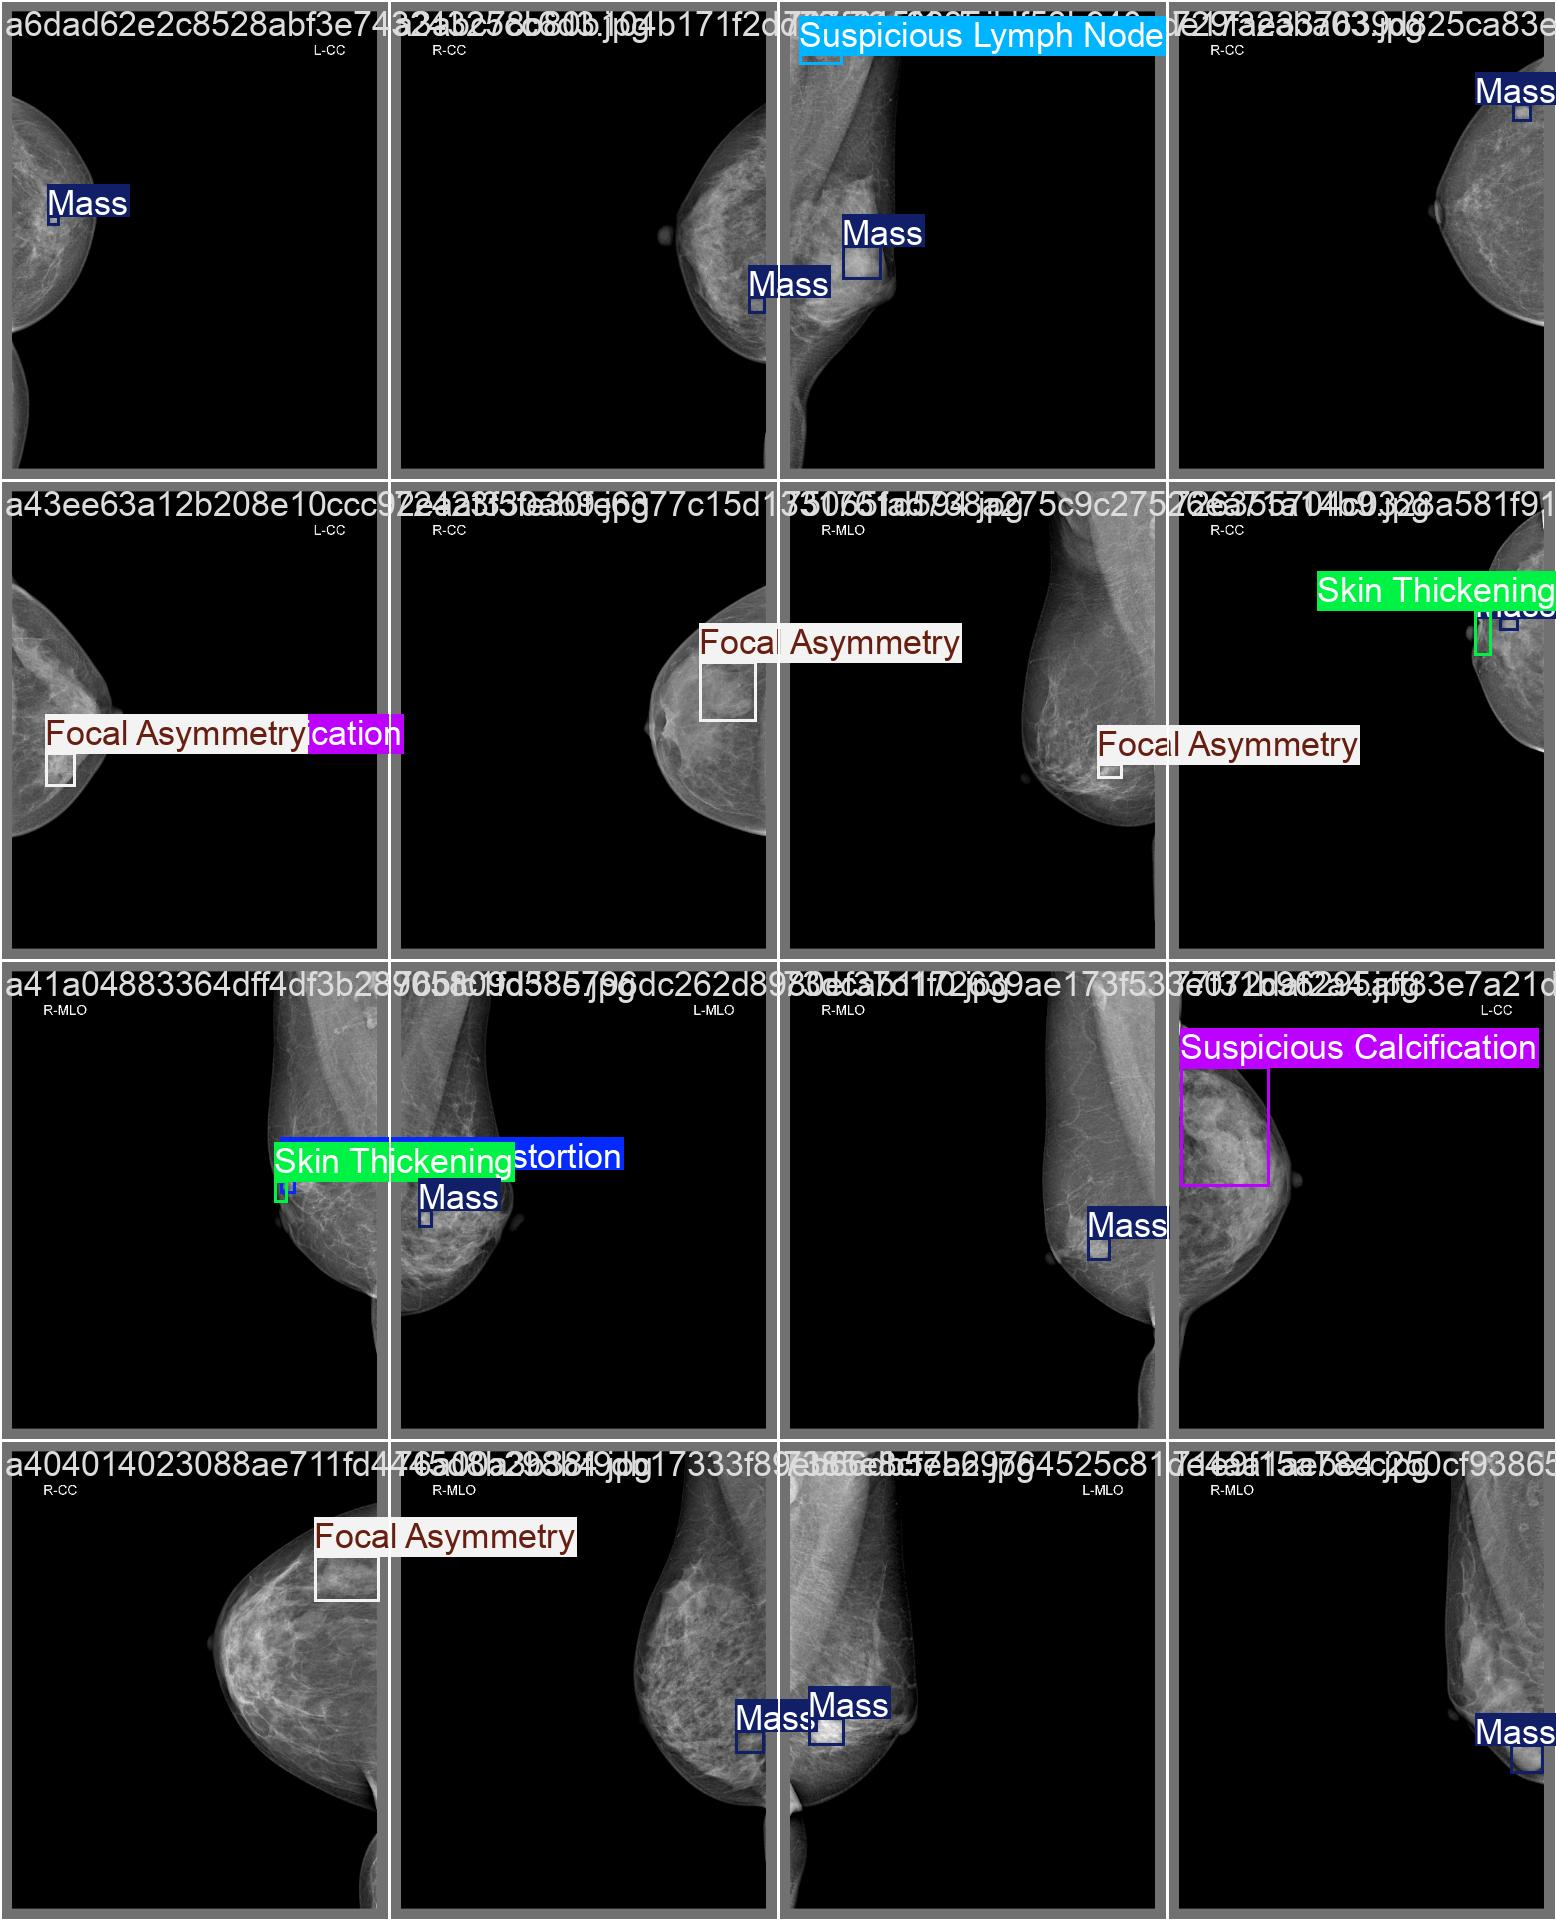
    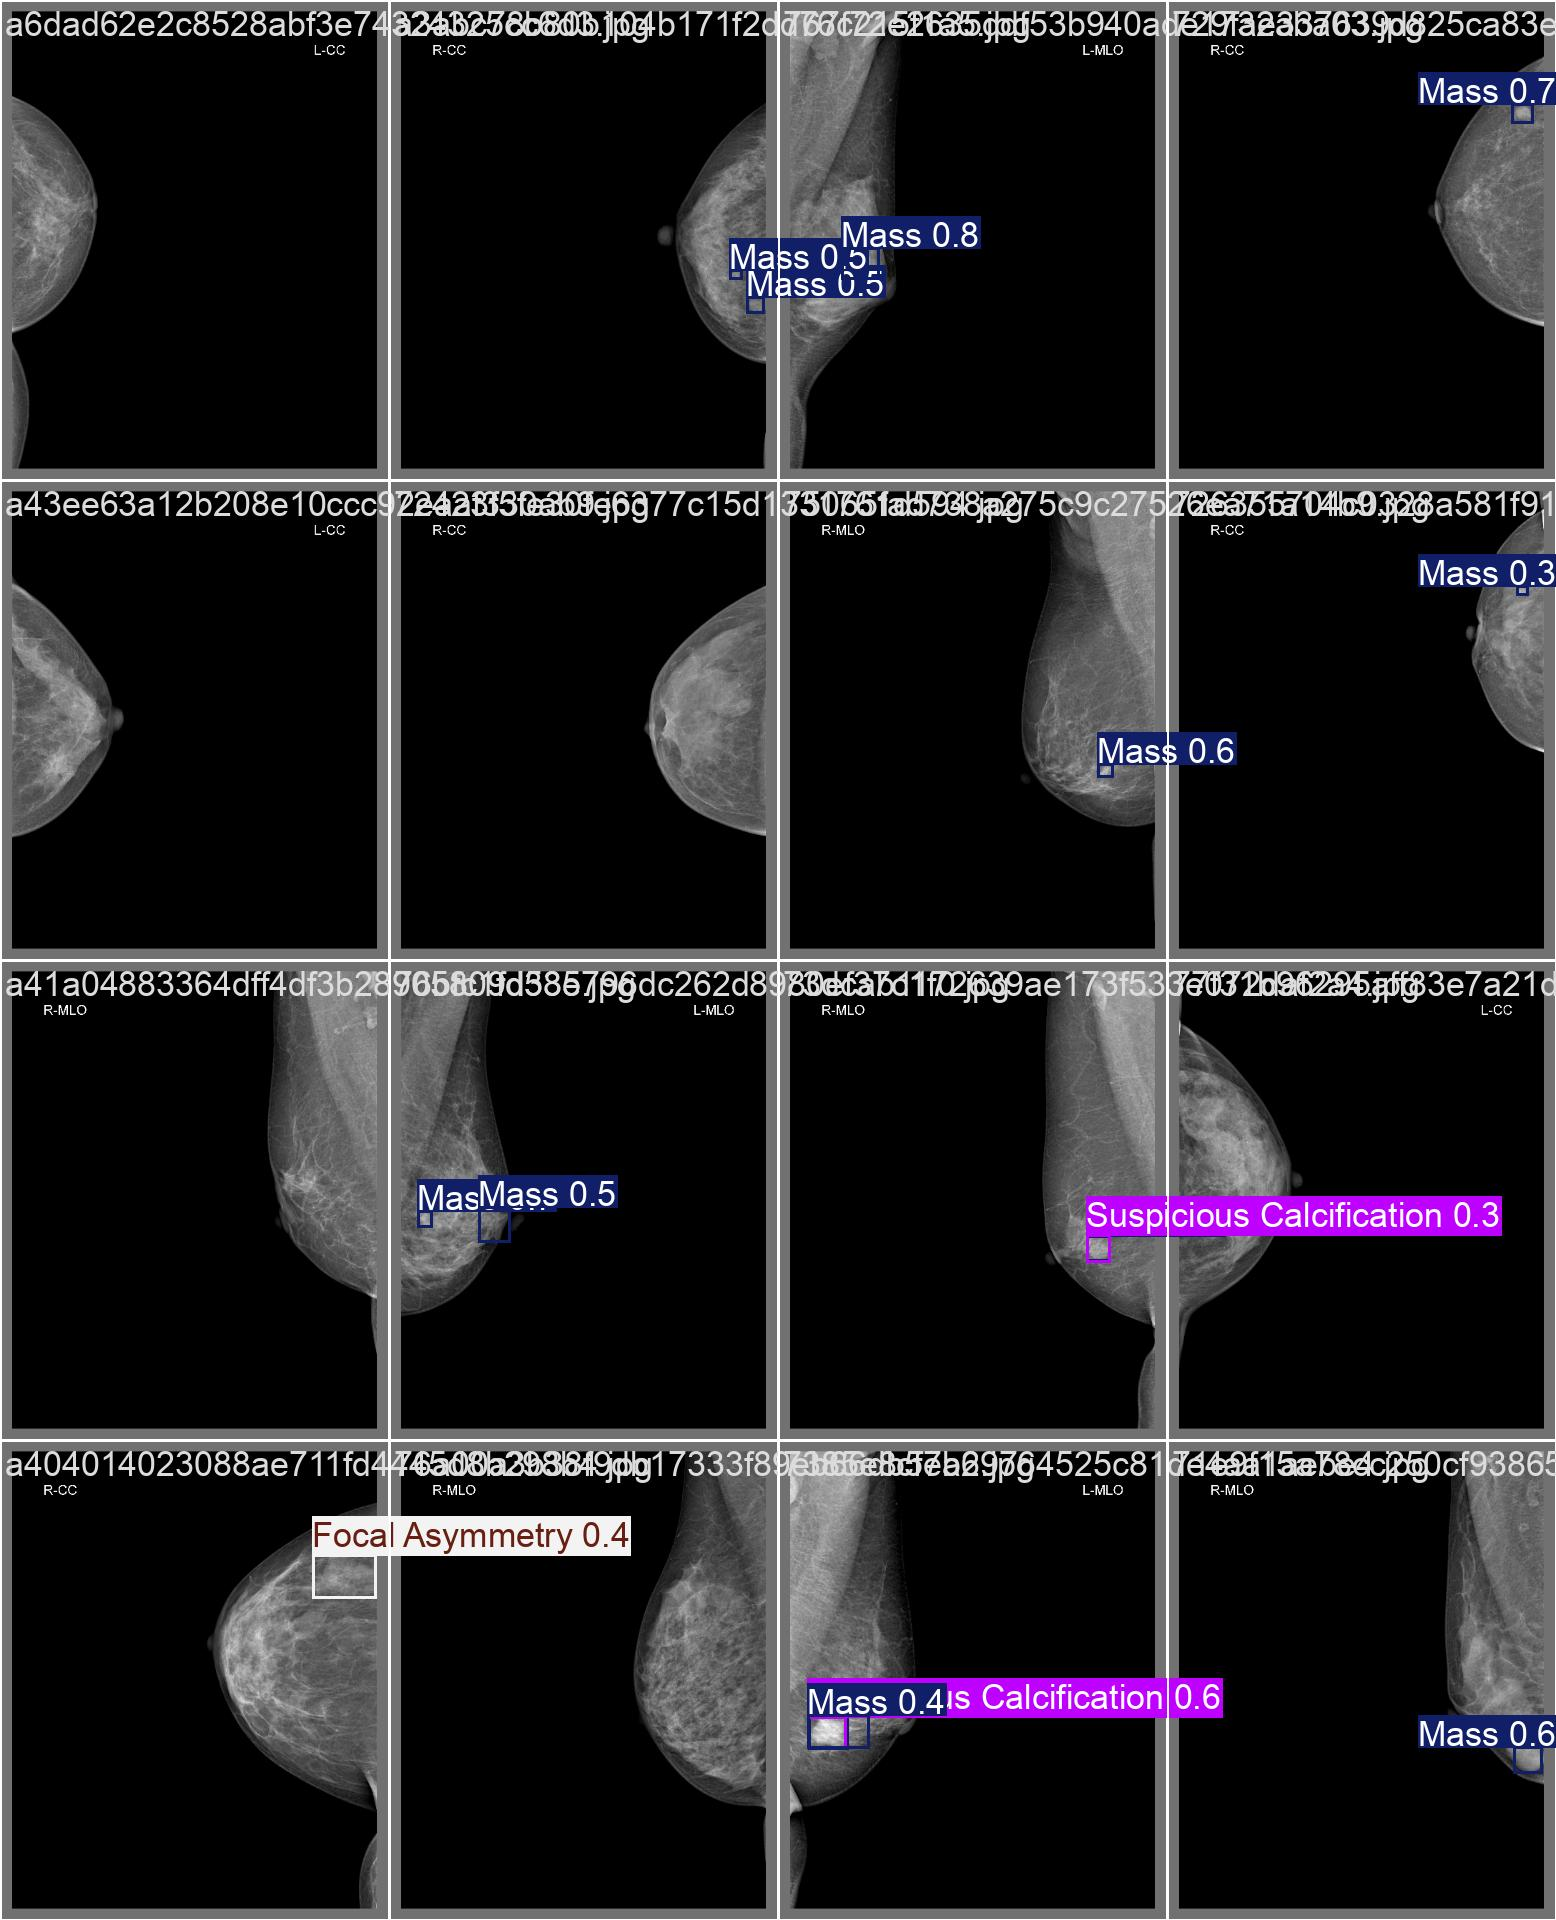
</div>

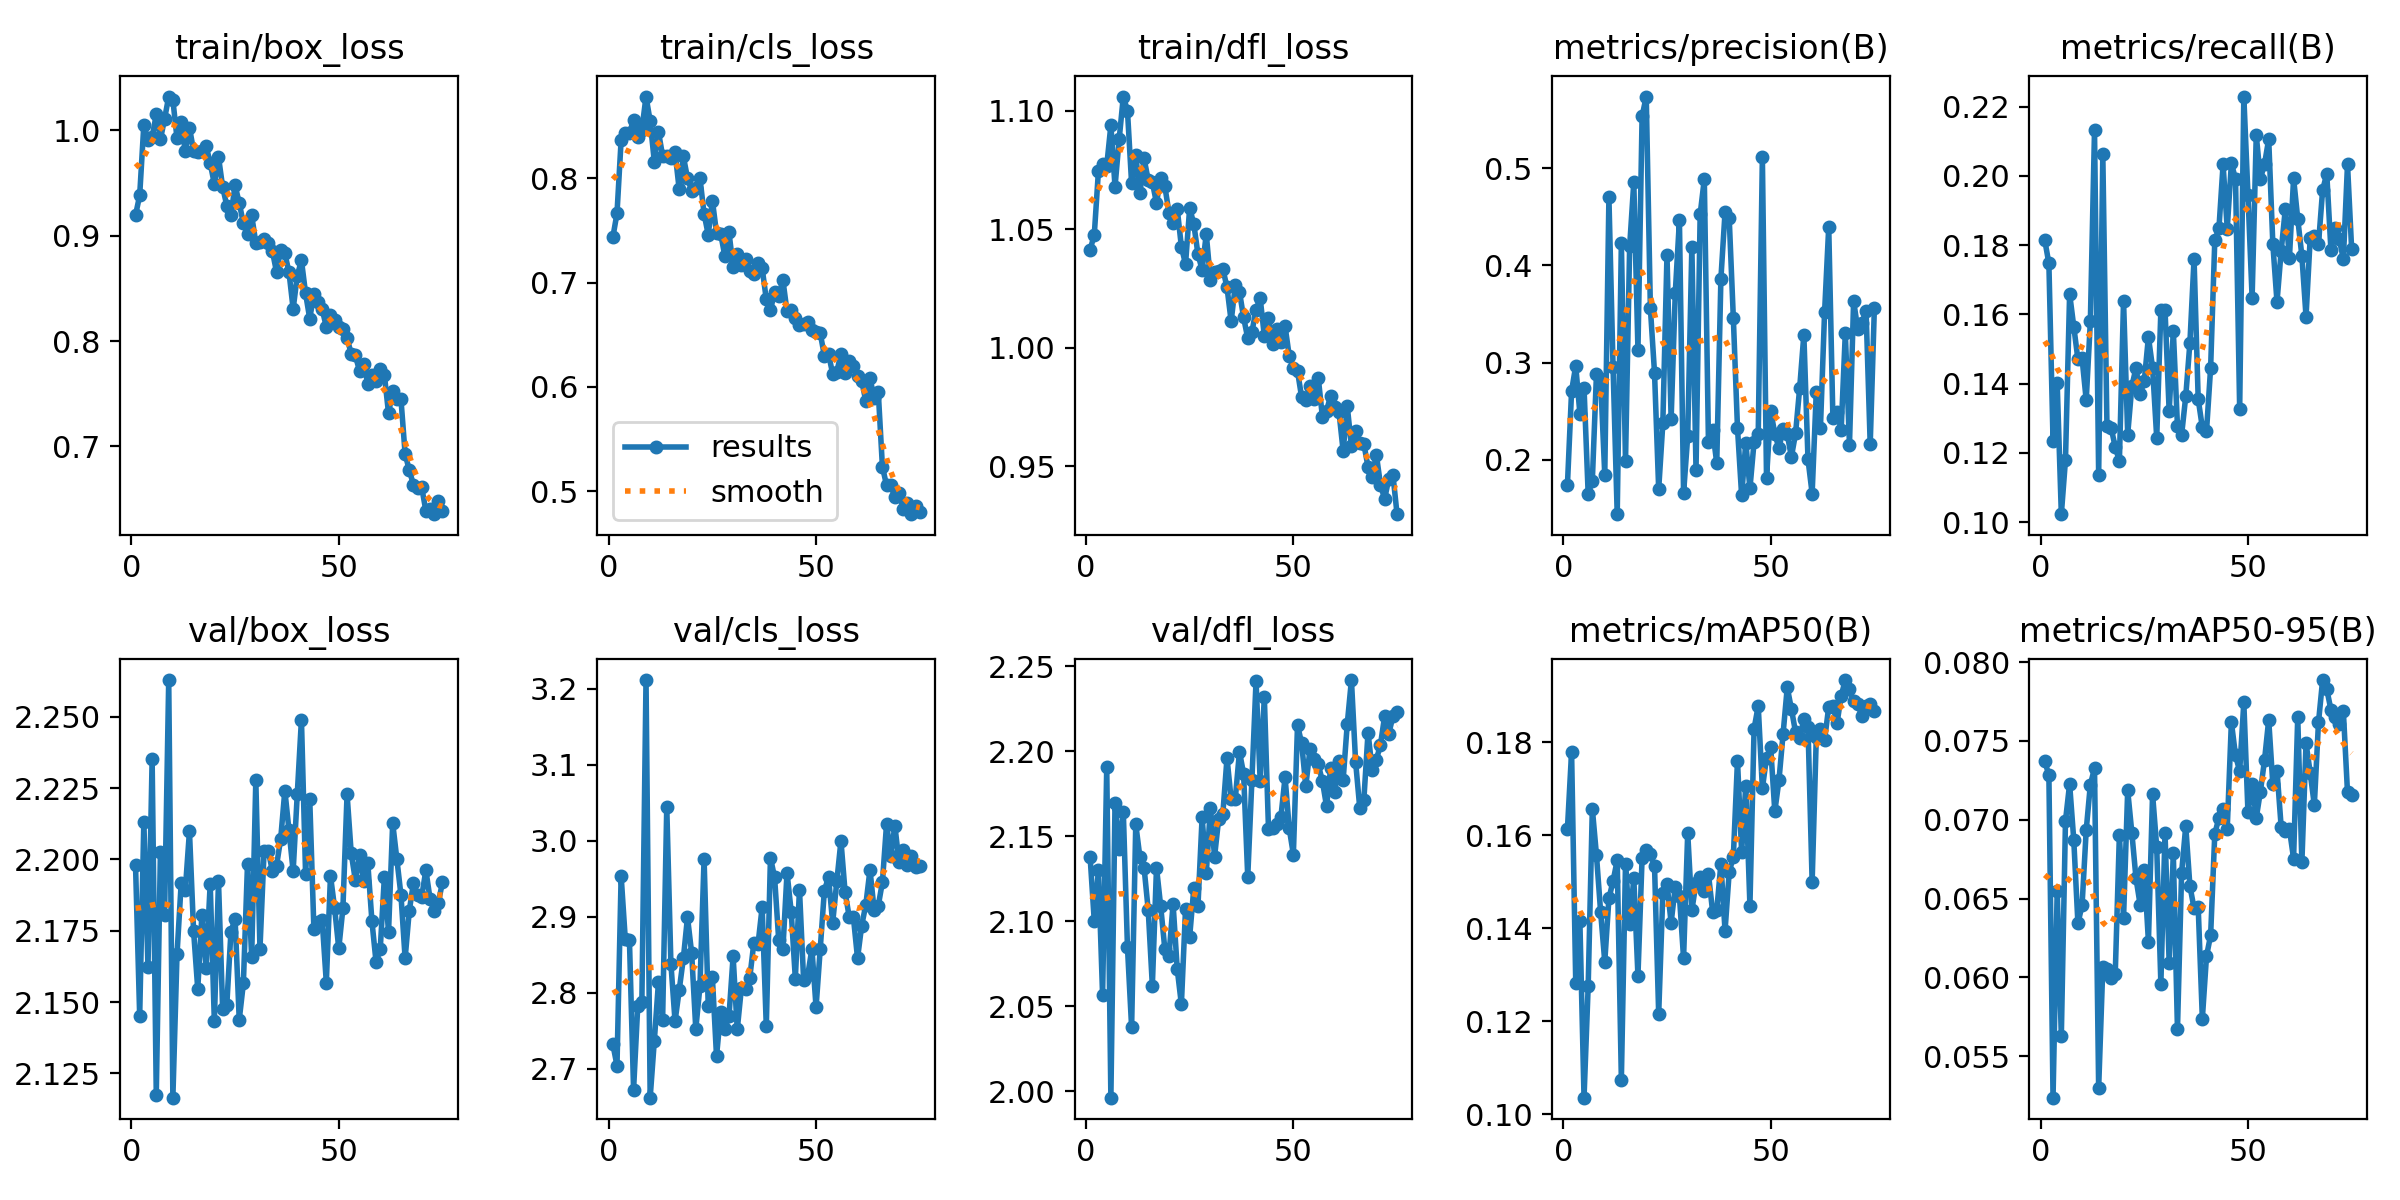

#### 5.3.2 Eğitim Hakkında Yorum

###### Genel Eğitim Paremetreleri
* Eğitim sırasında YOLOv11 Large modelini kullandım. Ancak sınıflar arasında ciddi bir dengesizlik vardı. Örneğin, Mass sınıfında 989 örnek bulunurken, Skin Retraction sadece 15 örneğe sahipti. Benzer şekilde, doğrulama verilerinde de sınıflar arasında benzer bir dengesizlik görüldü. Bu durum, az sayıda örneği olan sınıfların öğrenim sürecinde geride kalmasına ve modelin bu sınıflarda düşük performans göstermesine neden oldu.

* Eğitim, Colab’ın sınırlamaları nedeniyle 118. epoch'ta durdu. Eksik kalan eğitim sürecini tamamlamak için fine-tuning yaparak modeli 75 epoch daha eğittim. Bu aşamada parametrelerimi şu şekilde belirledim:

* epochs=1000: Eğitim süresince modelin öğrenme eğrilerini daha iyi analiz etmek ve yeterince optimize etmek için uzun bir epoch sayısı belirledim.(ancak colab sınırı yüzünden eğitim durdu , tekrar başlattım ve toplamda 2 kez fine - tuning ile beraber yaklaşık 275 epoch olmuştur.)
* imgsz=640: Daha küçük bir görüntü boyutu kullanarak modelin hızını artırmayı hedefledim. Özellikle Colab üzerinde kaynakların sınırlı olması nedeniyle bu boyut uygun bir denge sağladı.
* batch=8: Yine Colab GPU belleğinin sınırlı olması nedeniyle bu batch boyutunu seçtim. Daha büyük bir batch boyutu belleği aşabilir ve eğitim sürecini durdurabilirdi.
* workers=8: Veri yükleme sırasında işlemleri hızlandırmak için işçi sayısını artırdım.
* device=0: GPU’yu tam performansta kullanmak için bu parametreyi ekledim.
* Epoch sayısını ikinci eğitimde 75 olarak belirlememin nedeni, Colab sınırlamalarını aşmaktı. Modeli gereğinden fazla eğitmek yerine, fine-tuning sırasında az bir miktar daha eğitim yaparak eksik kalan kısmı tamamlamayı hedefledim.

###### Sonuç Grafikleri: 
* Train Box Loss, Train Cls Loss, Train DFL Loss: Bu kayıpların düzenli bir şekilde azaldığını gördüm, bu da modelin veriyi öğrendiğini ve hatalarını azalttığını gösteriyor.
* Precision ve Recall: Dalgalı bir seyir izlese de genel olarak bir artış trendi mevcut. Ancak sınıflar arasındaki dengesizlik bu metriklerdeki tutarsızlığa neden olabilir.
* mAP50-95: Performans göstergesi olarak, modelin farklı IoU eşiklerinde ortalama hassasiyetini ölçüyor. Bu metrikteki kademeli artış, modelin genel performansının iyileştiğini, ancak sınıf dengesizliği nedeniyle hala düşük performans gösteren sınıflar olabileceğini işaret ediyor.
* Genel olarak, eğitim süreci başarılı bir şekilde ilerledi, ancak sınıf dengesizliği model performansını sınırlayan en büyük sorun olarak dikkat çekiyor. Sonraki aşamalarda az örneğe sahip sınıflar için data augmentation ve class weights gibi teknikler kullanmayı planlıyorum. Ayrıca, sınıf dengesini iyileştirmek için daha dengeli bir veri kümesi oluşturmayı hedefliyorum.

## 5.3.3 Modelin Hiç Görmediği İnternetten Bulunan Birkaç Görüntüde Model Test Edildi

## model_test.py

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Model ve görüntü yollarını tanımla
model_path = r"C:\Users\Monster\Desktop\Tubitak İTÜ\resume2\trained_data_resume2\weights\best.pt"
#"C:\Users\Monster\Desktop\Tubitak İTÜ\1.eğitim\runs\runs\detect\trained_data\weights\best.pt"
image_path = r"C:\Users\Monster\Desktop\mamografi-ankara.jpg"
#"C:\Users\Monster\Desktop\mamografi-scaled.jpg"
# YOLO modelini yükle
model = YOLO(model_path)

# Görüntüyü yükle
img = cv2.imread(image_path)

# OpenCV BGR okur, RGB'ye dönüştürelim
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Model ile tahmin yap
results = model.predict(source=img_rgb, save=False, save_txt=False)

# Tahmin edilen sonuçları göster
annotated_frame = results[0].plot()  # Modelin anotasyonlu çıktısı

# RGB görüntüyü göster
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### 5.3.4 İlk Eğitilmiş Model Çıktısı

<div style="display: flex; align-items: center; gap: 0px; justify-content: flex-start;">
    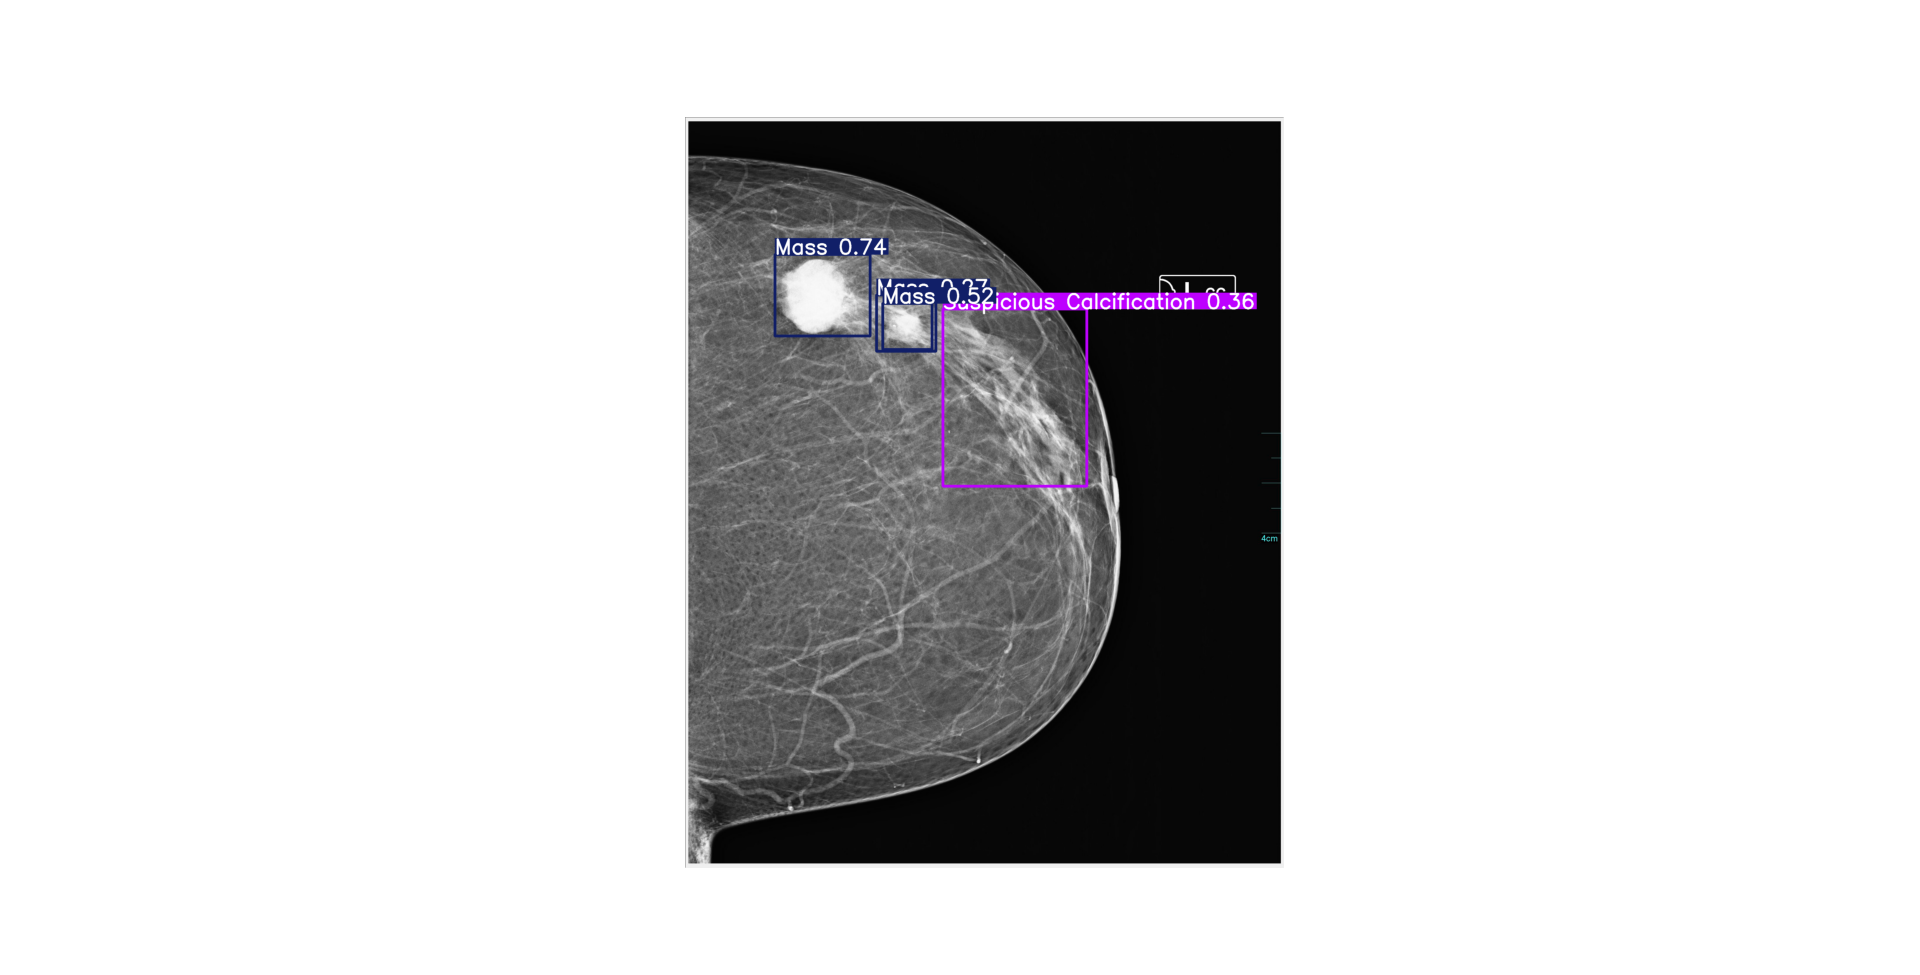
    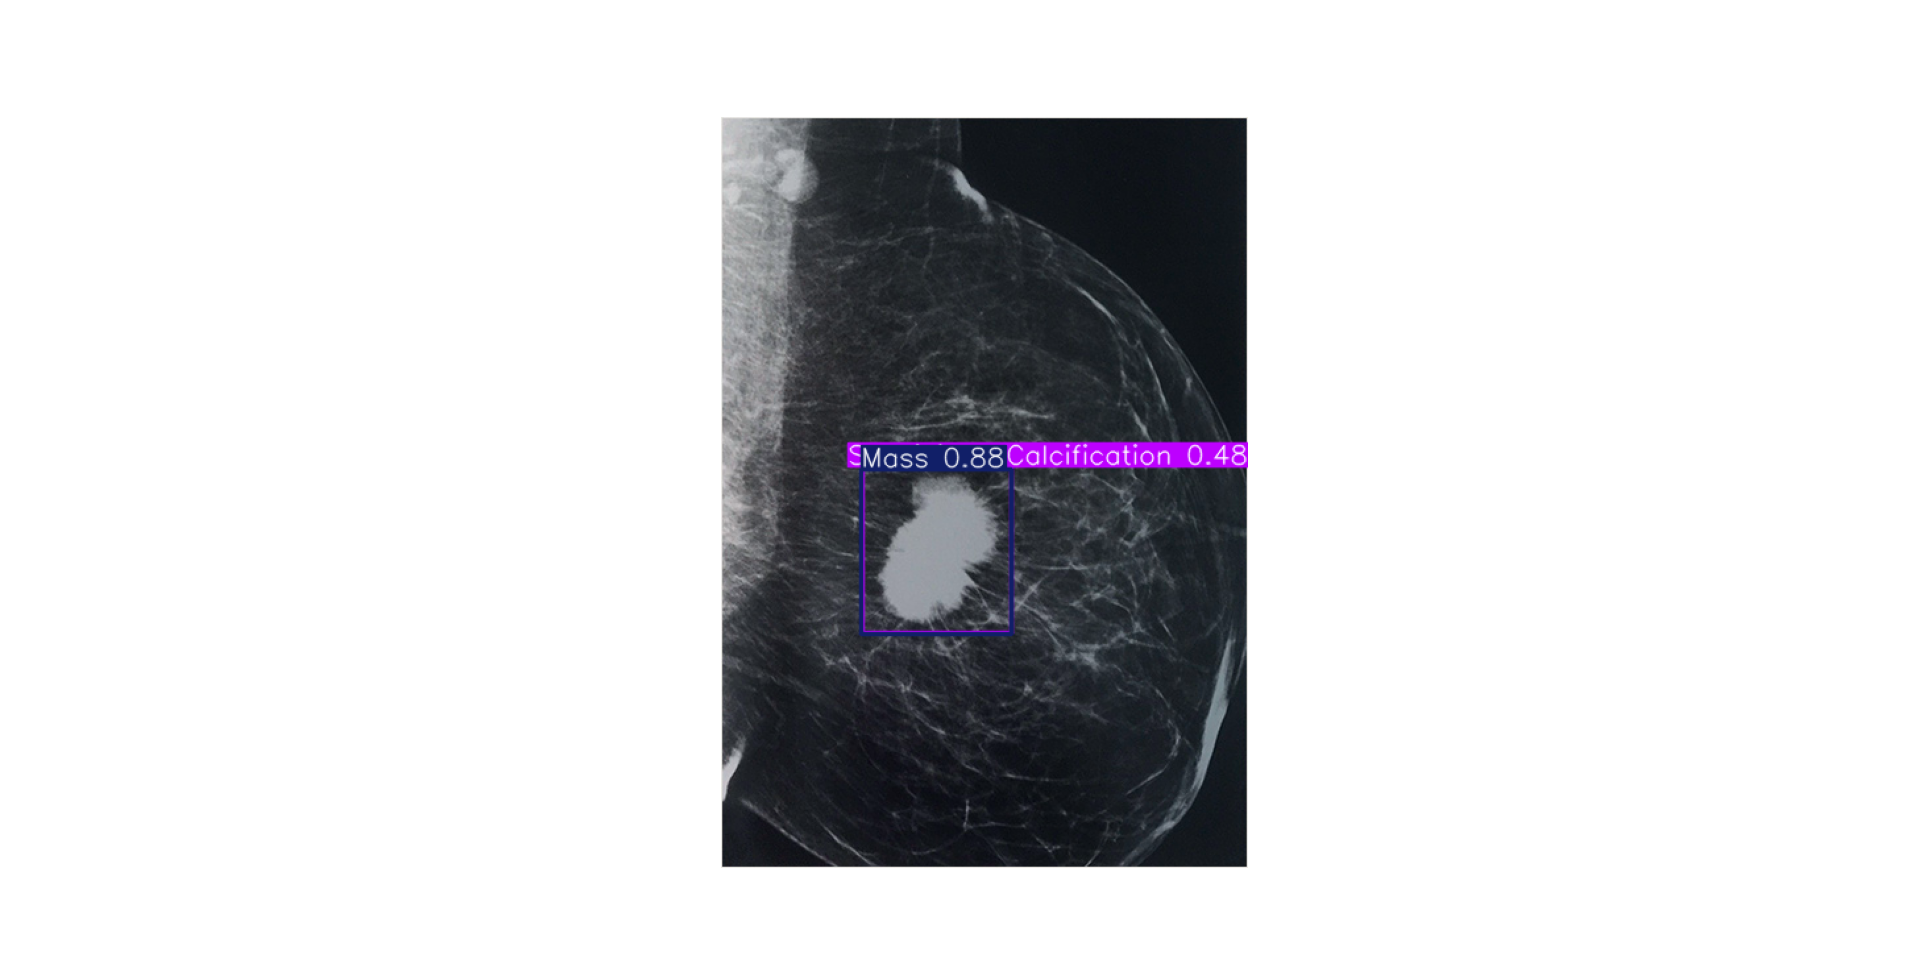
</div>


### 5.3.5 Fine Tuning Yapılmış Model Çıktısı


<div style="display: flex; align-items: center; gap: 0px; justify-content: flex-start;">
    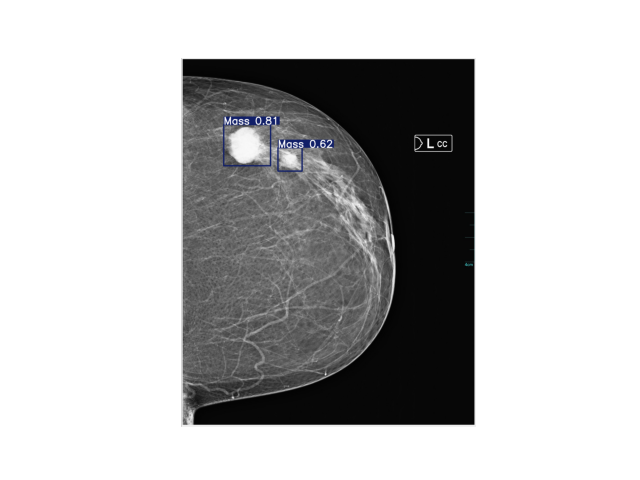
    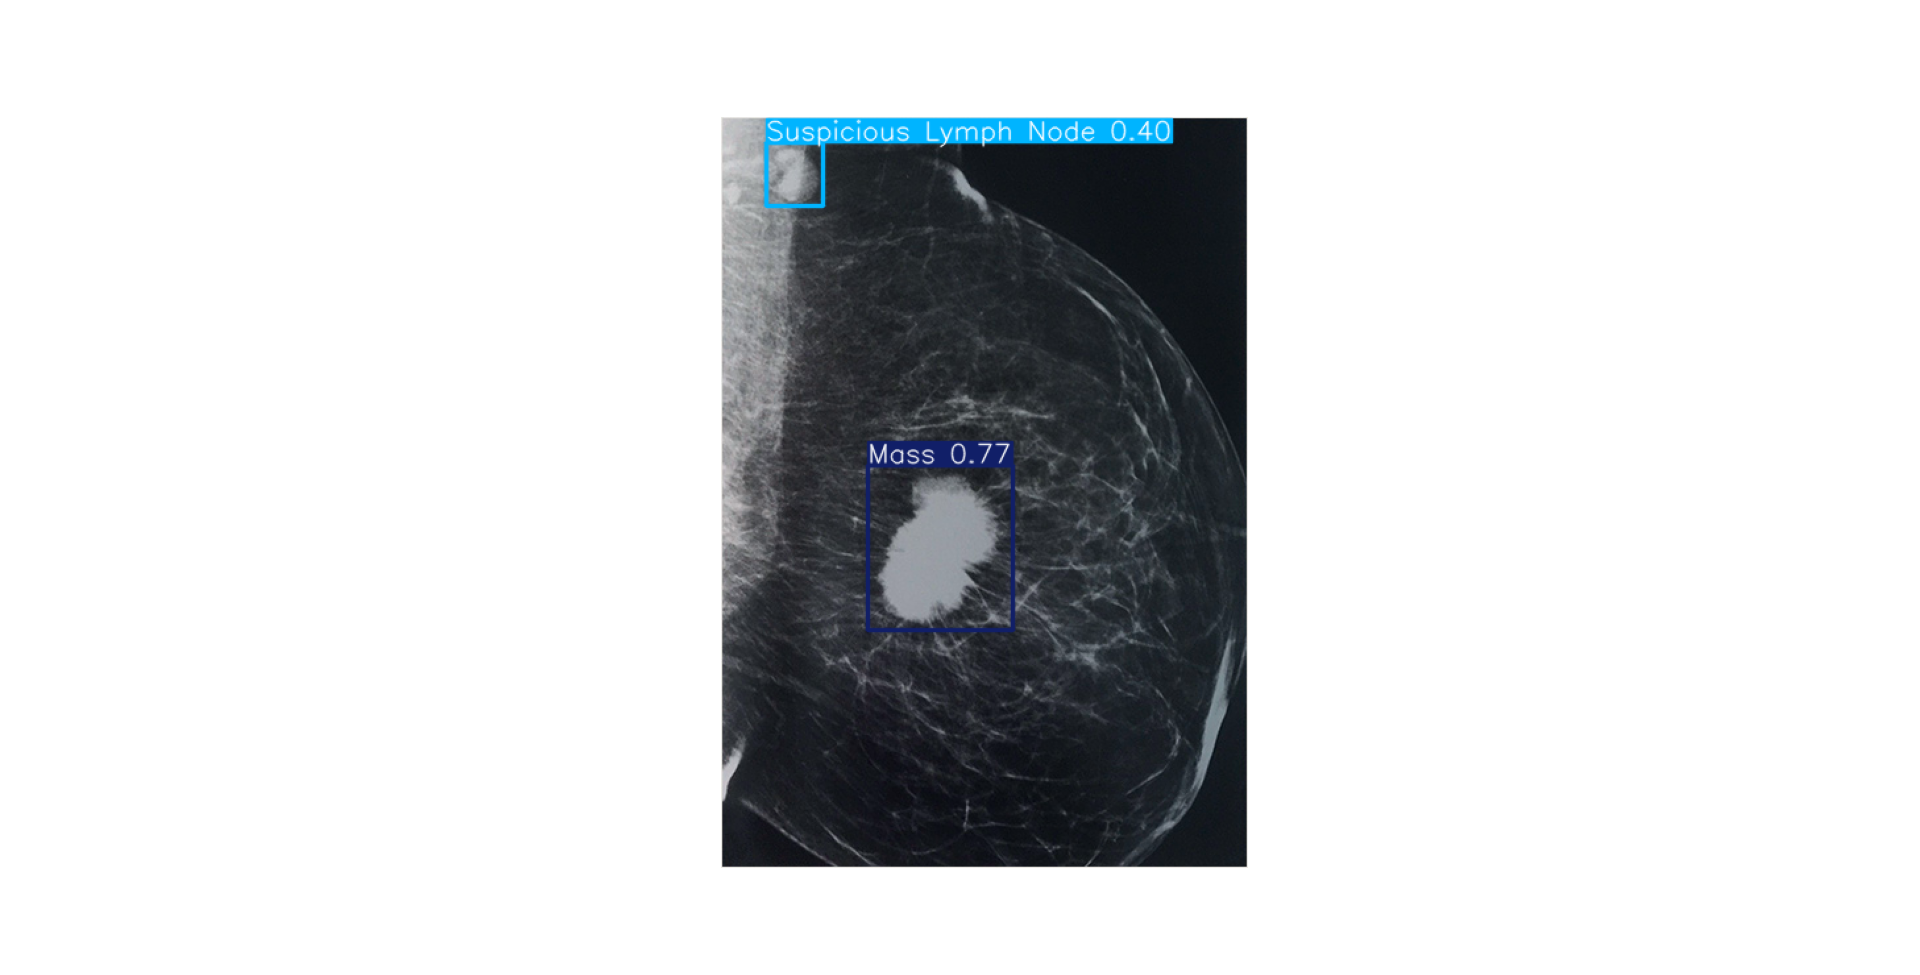
</div>


* Yukarıda iki mamografi görüntüsü üzerinde önce colab erişim sınırı yüzünden 118. epoch'ta eğitimğin bittiği model ve devamında fine tuning yapılarak eğitime 75 epoch daha devam edilen görüntüler var.
* Bu görüntülere göre model eğitime devam edildiğinde veri sayısı olarak daha fazla olan sınıfların tespiti ve kutucuk işaretlemesi daha iyi yönde ilerlemiş diyebiliriz.
* Veri sayısı olarak diğer sınıflara göre az olan sınıflarda ise fine tuning sonrasında ki modelin testinde tespit yapılamamıştır.

# 6. Daha İyi Bir Eğitim İçin Veri Arttırımı + Verileri PNG Format Olarak Eğitmek

##### Değişiklikler:
* GOOGLE COLAB kullanım sınırını aşmamak için 100 epoch verildi , diğer parametreler aynı şekilde bırakıldı.
* Veri dengesizliği çözülmesi için eksik verileri veri arttırımı yaparak iyileştirme yapıldı.
* Görüntüler Dicom formattan PNG formata çevrildi.(Daha detaylı veriler oluşacağı öngörüldü)
* mass sınıfı hiç çoğaltılmadı , Suspicious Calcification sınıfı yalnızca 2 kat arttırıldı.
* Diğer tüm sınıflar Horizontal Flip (Yatay Ayna), Vertical Flip (Dikey Ayna), Both (Hem Yatay Hem Dikey Ayna) olarak görüntüler ve ilgili görüntülerin etiketleri çoğaltıldı.
  

### 6.1 Çoğaltma İşleminin yapılması

##### Kodda üç tür yansıma (flip) işlemi uygulanmaktadır:


##### class_id / x_center /  y_center / width height  → şeklinde olan yolo formattaki etiketlerimiz için:

* Horizontal (Yatay): Görüntü yatayda çevrilir (sol-sağ).
    * Görüntü yatayda çevrilirse, xmerkez (x koordinatının merkezi) tersine çevrilir.
        * xmerkez = xmerkez - 1

          
* Vertical (Dikey): Görüntü dikeyde çevrilir (üst-alt).
    * Görüntü dikeyde çevrilirse, ymerkez (y koordinatının merkezi) tersine çevrilir. 
        * ymerkez = ymerkez - 1
     
        
* Both (Her iki yönde): Görüntü hem yatay hem dikey çevrilir.
    * Görüntü hem yatay hem dikey çevrilirse, hem xmerkez hem de ymerkez tersine çevrilir.
        * xmerkez = xmerkez - 1 ve ymerkez = ymerkez - 1 işlemlerin etkisi birleştirilir.

## augment_images_labels.py

In [ ]:
import cv2
import os
import numpy as np
from collections import defaultdict

# Veri dizinleri: Eğitim ve doğrulama setlerinin görüntü ve etiket dosyalarının konumları
train_image_dir = r"C:\Users\Monster\Desktop\dataset\images\train"
train_label_dir = r"C:\Users\Monster\Desktop\dataset\labels\train"
val_image_dir = r"C:\Users\Monster\Desktop\dataset\images\val"
val_label_dir = r"C:\Users\Monster\Desktop\dataset\labels\val"

# Çoğaltma yapılmayacak sınıflar ve özel çoğaltma yapılacak sınıf tanımları
exclude_classes = [4]  # Mass sınıfı için çoğaltma yapılmayacak
duplicate_class = 9  # Suspicious Calcification sınıfı için özel olarak bir kez çoğaltma yapılacak 
# yalnızca 2 kat arttırmak istedim
class_counts = defaultdict(int)  # Her sınıf için veri sayısını izlemek

# Görüntü ve etiket dosyalarını eşleştiren yardımcı bir fonksiyon
def get_files(image_dir, label_dir):
    """
    Verilen görüntü ve etiket dizinlerindeki dosyaları eşleştirir.
    """
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')])
    return list(zip(image_files, label_files))

# Eğitim ve doğrulama veri setlerini yükle
train_files = get_files(train_image_dir, train_label_dir)
val_files = get_files(val_image_dir, val_label_dir)

# Görüntü ve etiketler üzerinde veri artırımı uygulayan fonksiyon
def augment_image_and_labels(image_path, label_path, output_image_dir, output_label_dir, special_class_id=None):
    """
    Bir görüntü ve etiket seti üzerinde veri artırımı işlemleri uygular.
    Flip (yansıtma) dönüşümleri ile yeni veri oluşturur.
    """
    image = cv2.imread(image_path)
    if image is None:
        return []  # Görüntü yüklenemezse boş dön

    height, width, _ = image.shape
    with open(label_path, "r") as f:
        labels = f.readlines()

    augmented_files = []

    # Yatay, dikey ve her iki yönde yansıma işlemleri
    for flip_name, flip_code in {"horizontal": 1, "vertical": 0, "both": -1}.items():
        flipped_image = cv2.flip(image, flip_code)  # Görüntüyü yansıt
        augmented_labels = []
        for label in labels:
            class_id, x_center, y_center, box_width, box_height = label.strip().split()
            class_id = int(class_id)

            # Özel sınıf için sadece bu sınıf üzerinde işlem yap
            if special_class_id is not None and class_id != special_class_id:
                continue

            # Hariç tutulan sınıflar üzerinde işlem yapma
            if class_id in exclude_classes and special_class_id is None:
                continue

            x_center = float(x_center)
            y_center = float(y_center)
            box_width = float(box_width)
            box_height = float(box_height)

            # Yansıma işlemleri için koordinat dönüşümleri
            if flip_name == "horizontal":
                x_center = 1 - x_center
            elif flip_name == "vertical":
                y_center = 1 - y_center
            elif flip_name == "both":
                x_center = 1 - x_center
                y_center = 1 - y_center

            # Yeni etiketleri oluştur
            augmented_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

        if augmented_labels:  # Eğer dönüşüm sonrası geçerli etiketler varsa, dosyayı kaydet
            base_name = os.path.basename(image_path).replace(".png", f"_aug_flip_{flip_name}.png")
            label_name = os.path.basename(label_path).replace(".txt", f"_aug_flip_{flip_name}.txt")
            augmented_image_path = os.path.join(output_image_dir, base_name)
            augmented_label_path = os.path.join(output_label_dir, label_name)
            cv2.imwrite(augmented_image_path, flipped_image)
            with open(augmented_label_path, "w") as f:
                f.writelines(augmented_labels)
            augmented_files.append((augmented_image_path, augmented_label_path))

    return augmented_files

# Veri seti üzerinde veri artırımı işlemi
def process_dataset(files, output_image_dir, output_label_dir):
    """
    Belirtilen dosyalar üzerinde veri artırımı işlemini uygular.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for image_path, label_path in files:
        with open(label_path, "r") as f:
            labels = f.readlines()
        for label in labels:
            class_id = int(label.split()[0])
            class_counts[class_id] += 1  # Her sınıf için veri sayısını artır

        # Suspicious Calcification sınıfı için özel veri artırımı
        augment_image_and_labels(image_path, label_path, output_image_dir, output_label_dir,
                                 special_class_id=duplicate_class)

        # Diğer sınıflar için genel veri artırımı
        augment_image_and_labels(image_path, label_path, output_image_dir, output_label_dir)

# Veri artırımı için çıkış dizinleri
augmented_train_image_dir = r"C:\Users\Monster\Desktop\augmented_dataset\images\train"
augmented_train_label_dir = r"C:\Users\Monster\Desktop\augmented_dataset\labels\train"
augmented_val_image_dir = r"C:\Users\Monster\Desktop\augmented_dataset\images\val"
augmented_val_label_dir = r"C:\Users\Monster\Desktop\augmented_dataset\labels\val"

# Eğitim ve doğrulama setlerine veri artırımı işlemini uygula
process_dataset(train_files, augmented_train_image_dir, augmented_train_label_dir)
process_dataset(val_files, augmented_val_image_dir, augmented_val_label_dir)

# Sınıf dağılımını yazdır
print("Veri dağılımı:")
for class_id, count in sorted(class_counts.items()):
    print(f"Sınıf {class_id}: {count} veri")


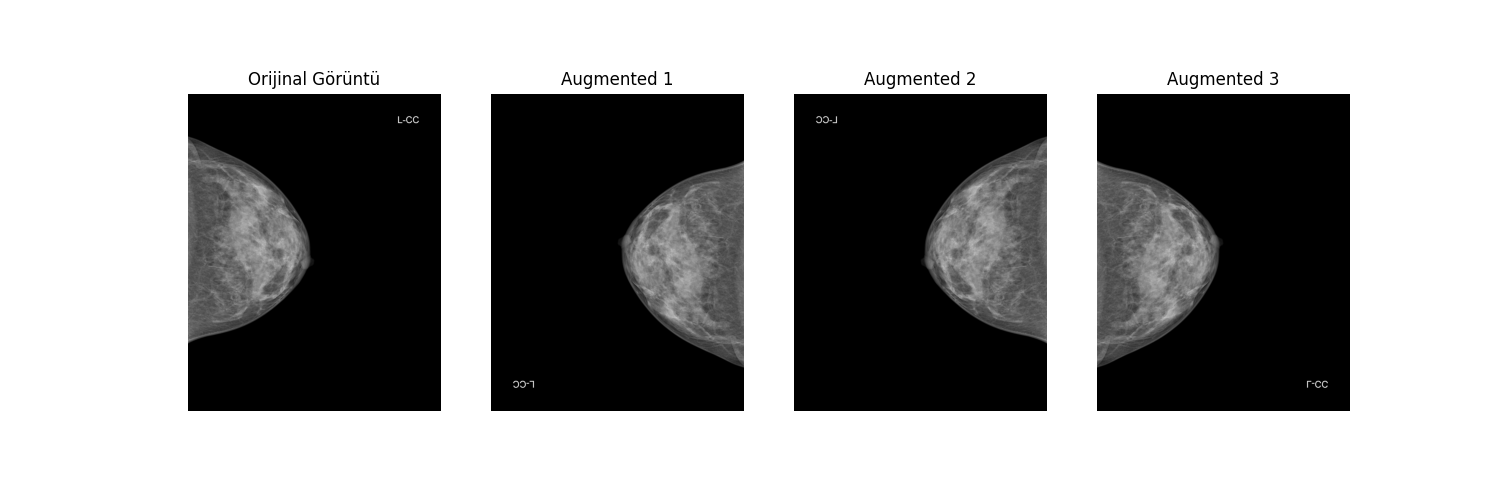

### 6.2 Çoğaltma İşleminden Sonra Toplam Veri Sayısı

#### Eğitim Verileri (Yeni):
* Mass: 989
* Suspicious Calcification: 856
* Focal Asymmetry: 432
* Architectural Distortion: 190
* Asymmetry: 154
* Skin Thickening: 90
* Suspicious Lymph Node: 92
* Nipple Retraction: 60
* Global Asymmetry: 40
* Skin Retraction: 30

#### Doğrulama Verileri (Yeni):
* Suspicious Calcification: 460
* Mass: 237
* Focal Asymmetry: 106
* Architectural Distortion: 48
* Suspicious Lymph Node: 22
* Asymmetry: 40
* Skin Thickening: 24
* Nipple Retraction: 14
* Global Asymmetry: 12
* Skin Retraction: 6

  
###  ÇOĞALTILDIKTAN SONRAKİ VERİ SAYISI
        * Eğitim verileri toplamı → 3793
        * Doğrulama verileri toplamı →  1241
### ÇOĞALTILMADAN ÖNCEKİ VERİ SAYISI 
        * Eğitim verileri toplamı → 1941
        * Doğrulama verileri toplamı →  488


* ##### Not : ÇOK İYİ BİR EĞİTİM İÇİN VERİLERİN BİRBİRİNE ÇOK YAKIN OLMASI GEREKMEKTEDİR ANCAK BU BİR SAĞLIK ALANINDA KULLANILACAK VERİ SETİ OLDUĞUNDAN YALNIZCA AYNALAMA İLE VERİ ÇOĞALTTIM çünkü  DİĞER ÇOĞALTMA TÜRLERİNİNİN GÖRÜNTÜLERİ KÖTÜ ETKİLEYEBİLECEĞİNİ DÜŞÜNDÜM. (TUZ BİBER , KONTRAST DEĞİŞTİRME, GÖRÜNTÜ KIRPMA VS..) 

# 7. Çoğaltılmış Görüntülerle YOLOv11-Medium Eğitimi

* Bir önceki eğitimde kullanılan her parametre sabit olarak alınmıştır yalnızca epoch sayısı 50 girilmiştir. (colab erişim sınırı yüzünden)
* Epoch sayısı 50 girilse dahi 38. epochta colab günlük kullanım miktarı dolmuştur ve eğitim sonlanmıştır. Bu yüzden tekrar fine-tuning yapılmıştır ve  20 epoch verilerek eğitimin sonuç grafikleri elde edilmiştir.

  
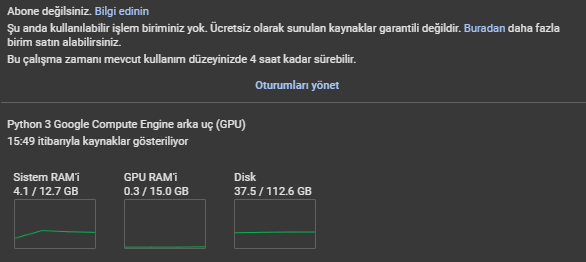

* Veri setini google drive 'a yüklemek jpg formattaki bir önceki eğitimden çok daha zor olmuştur çünkü png görüntülerinden oluşan veri seti olduğundan ve veriler arttırıldığından , 5 kat daha büyük veri seti boyutu olmuştur. (Normalde 10 dakikada yüklenen veri seti 1 saatte yüklenmiştir.)

### 7.1 Çoğaltılmış Görüntülerle Yapılan YOLOv11-Medium Eğitiminin Sonuç Görüntüleri

<div style="display: flex; justify-content: space-around; align-items: center;">
    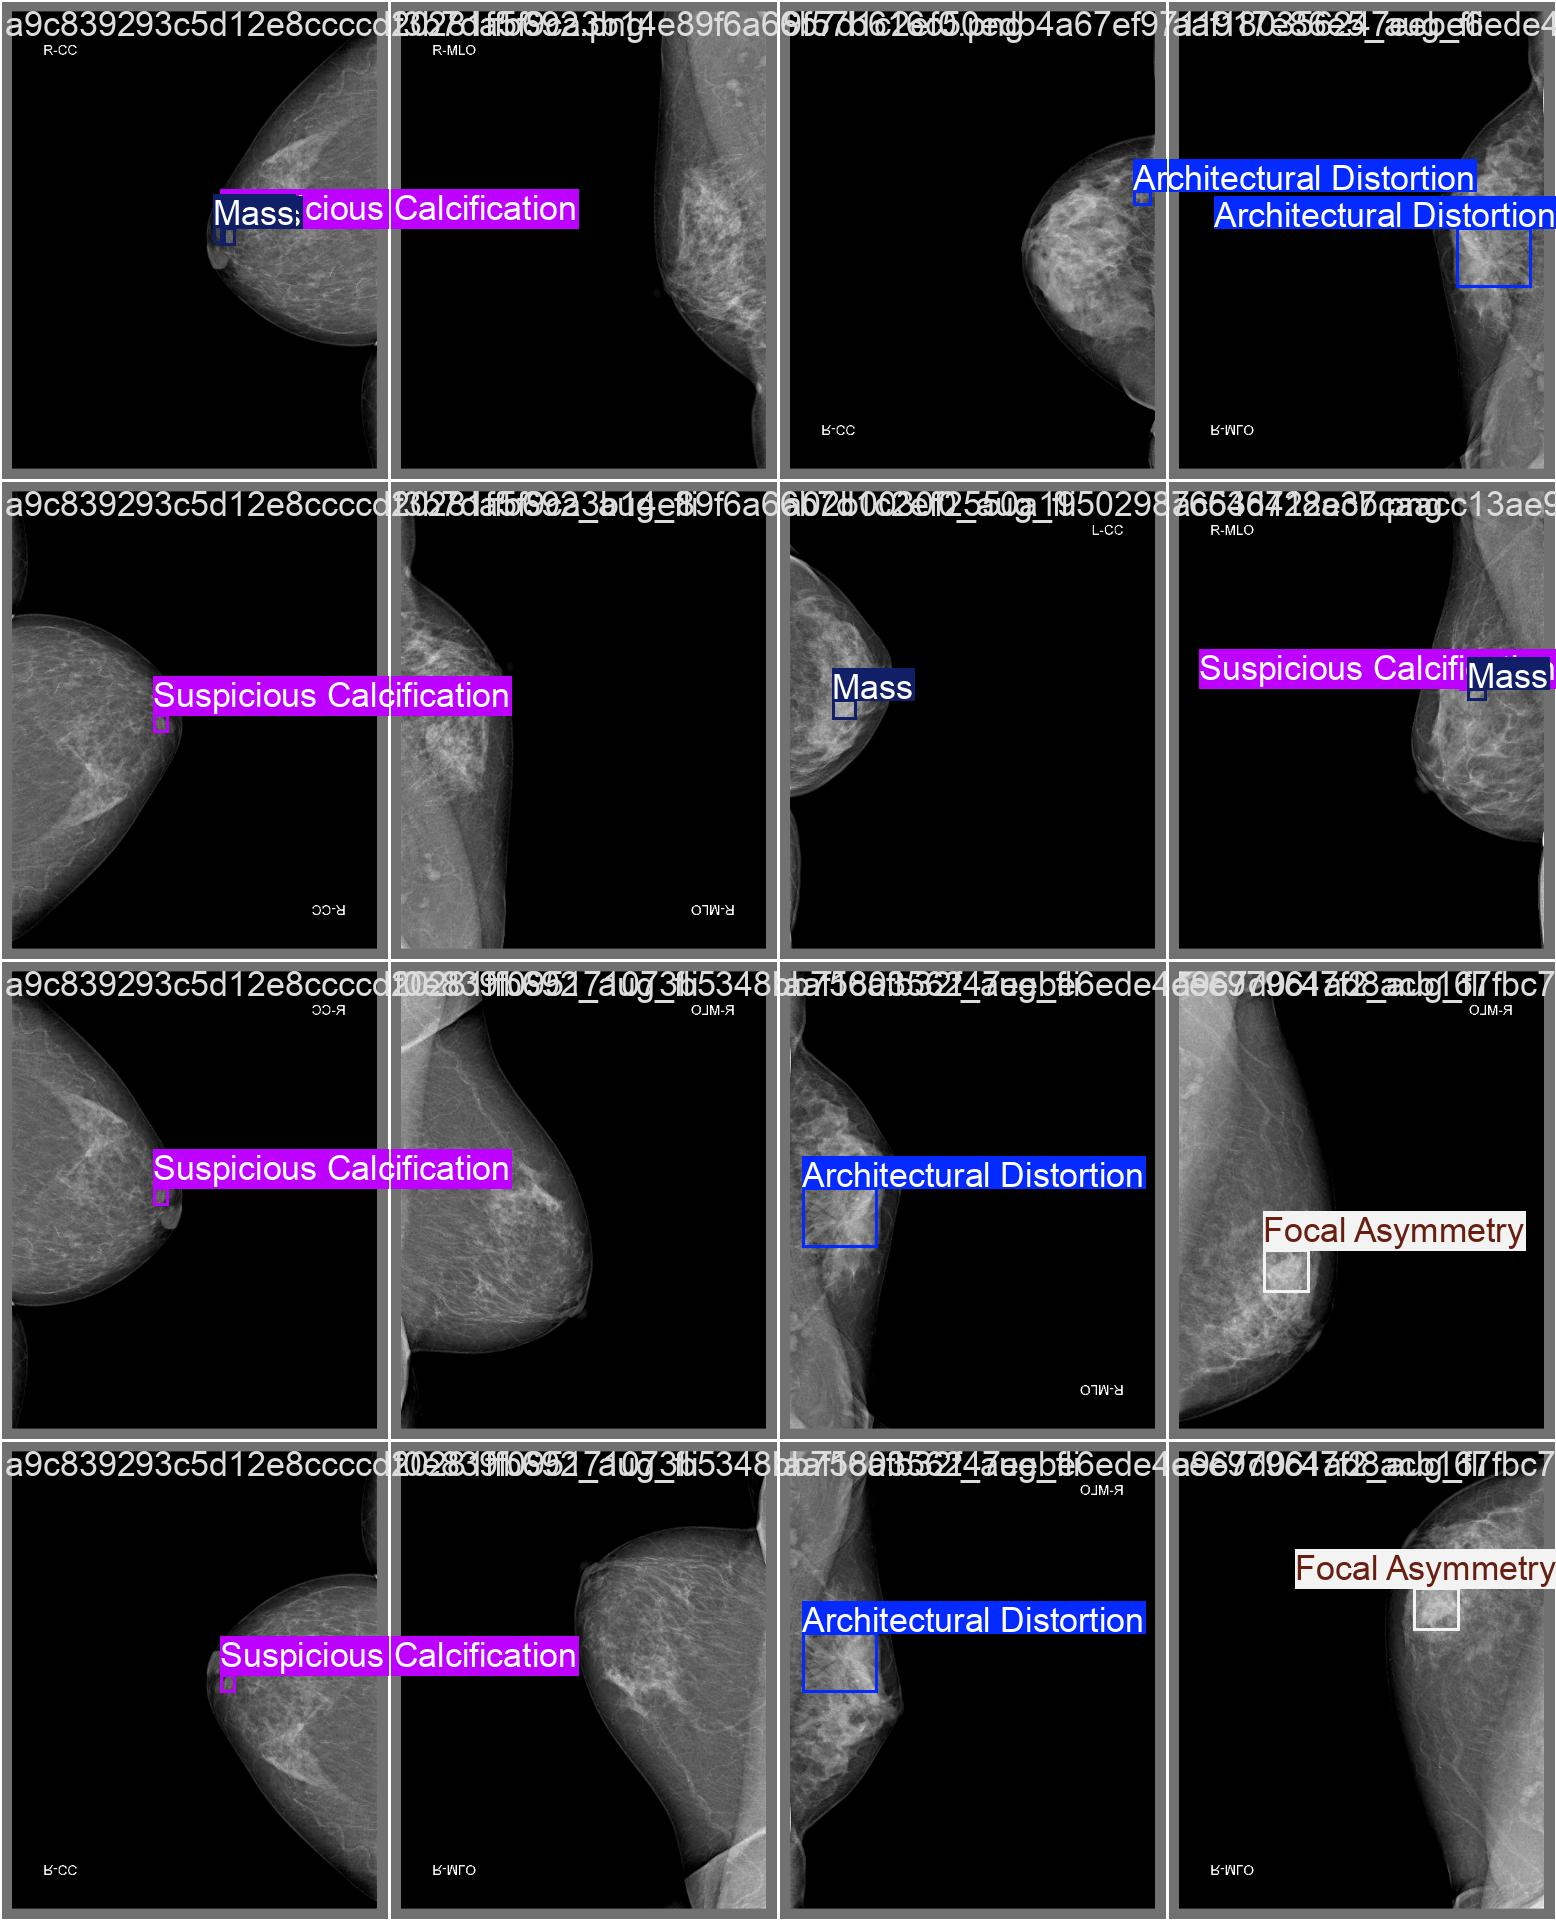
    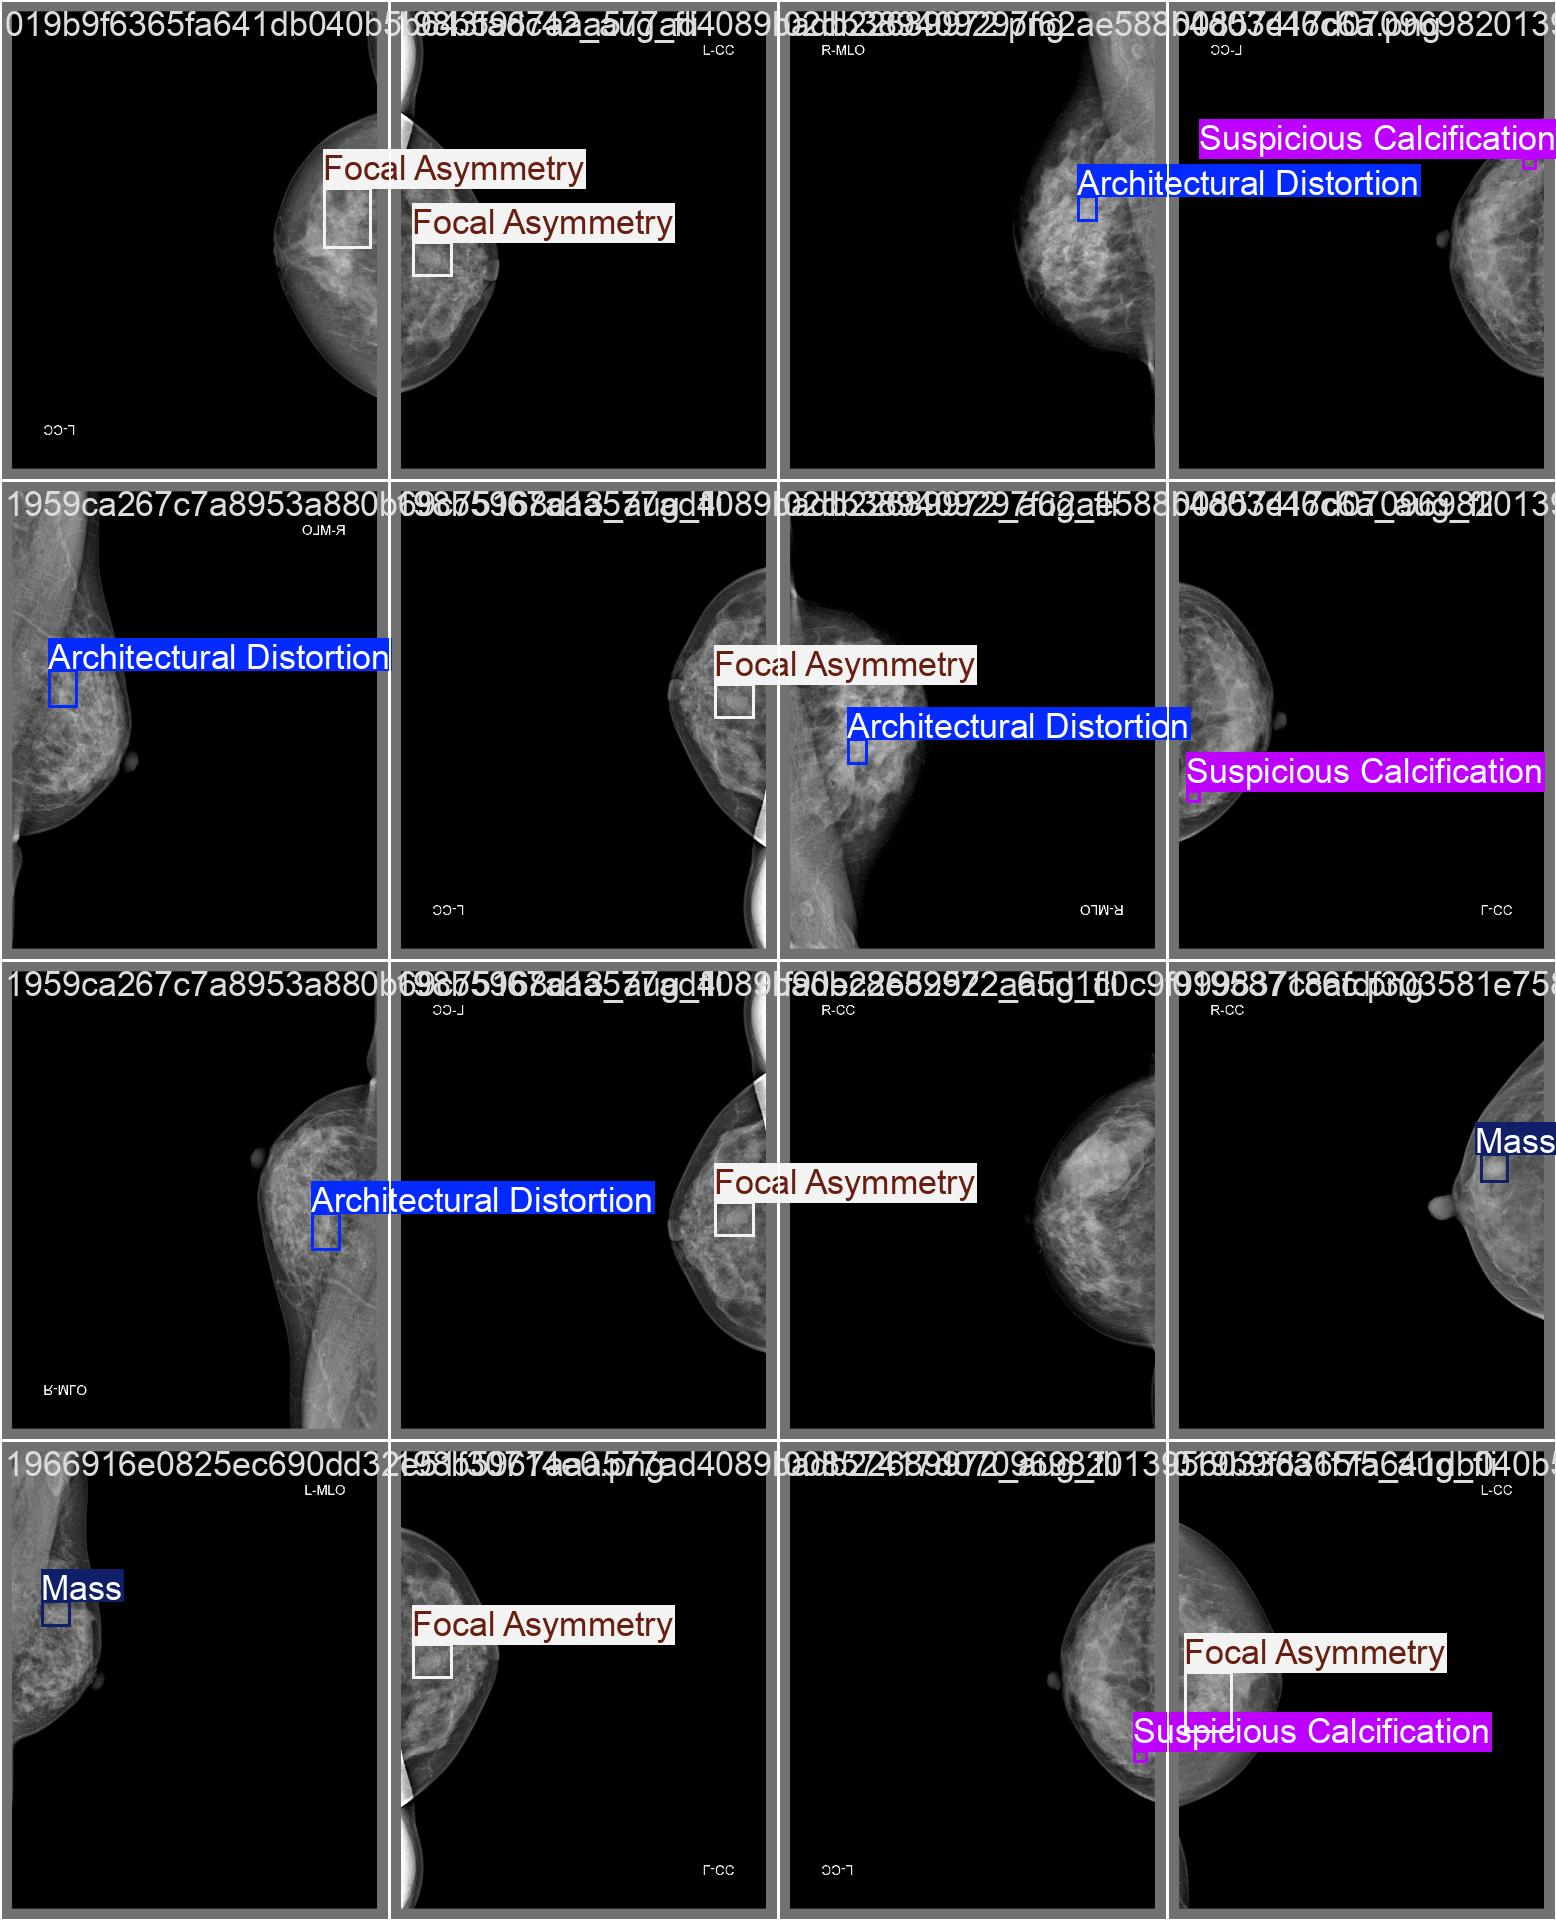
</div>

<div style="display: flex; justify-content: space-around; align-items: center;">
    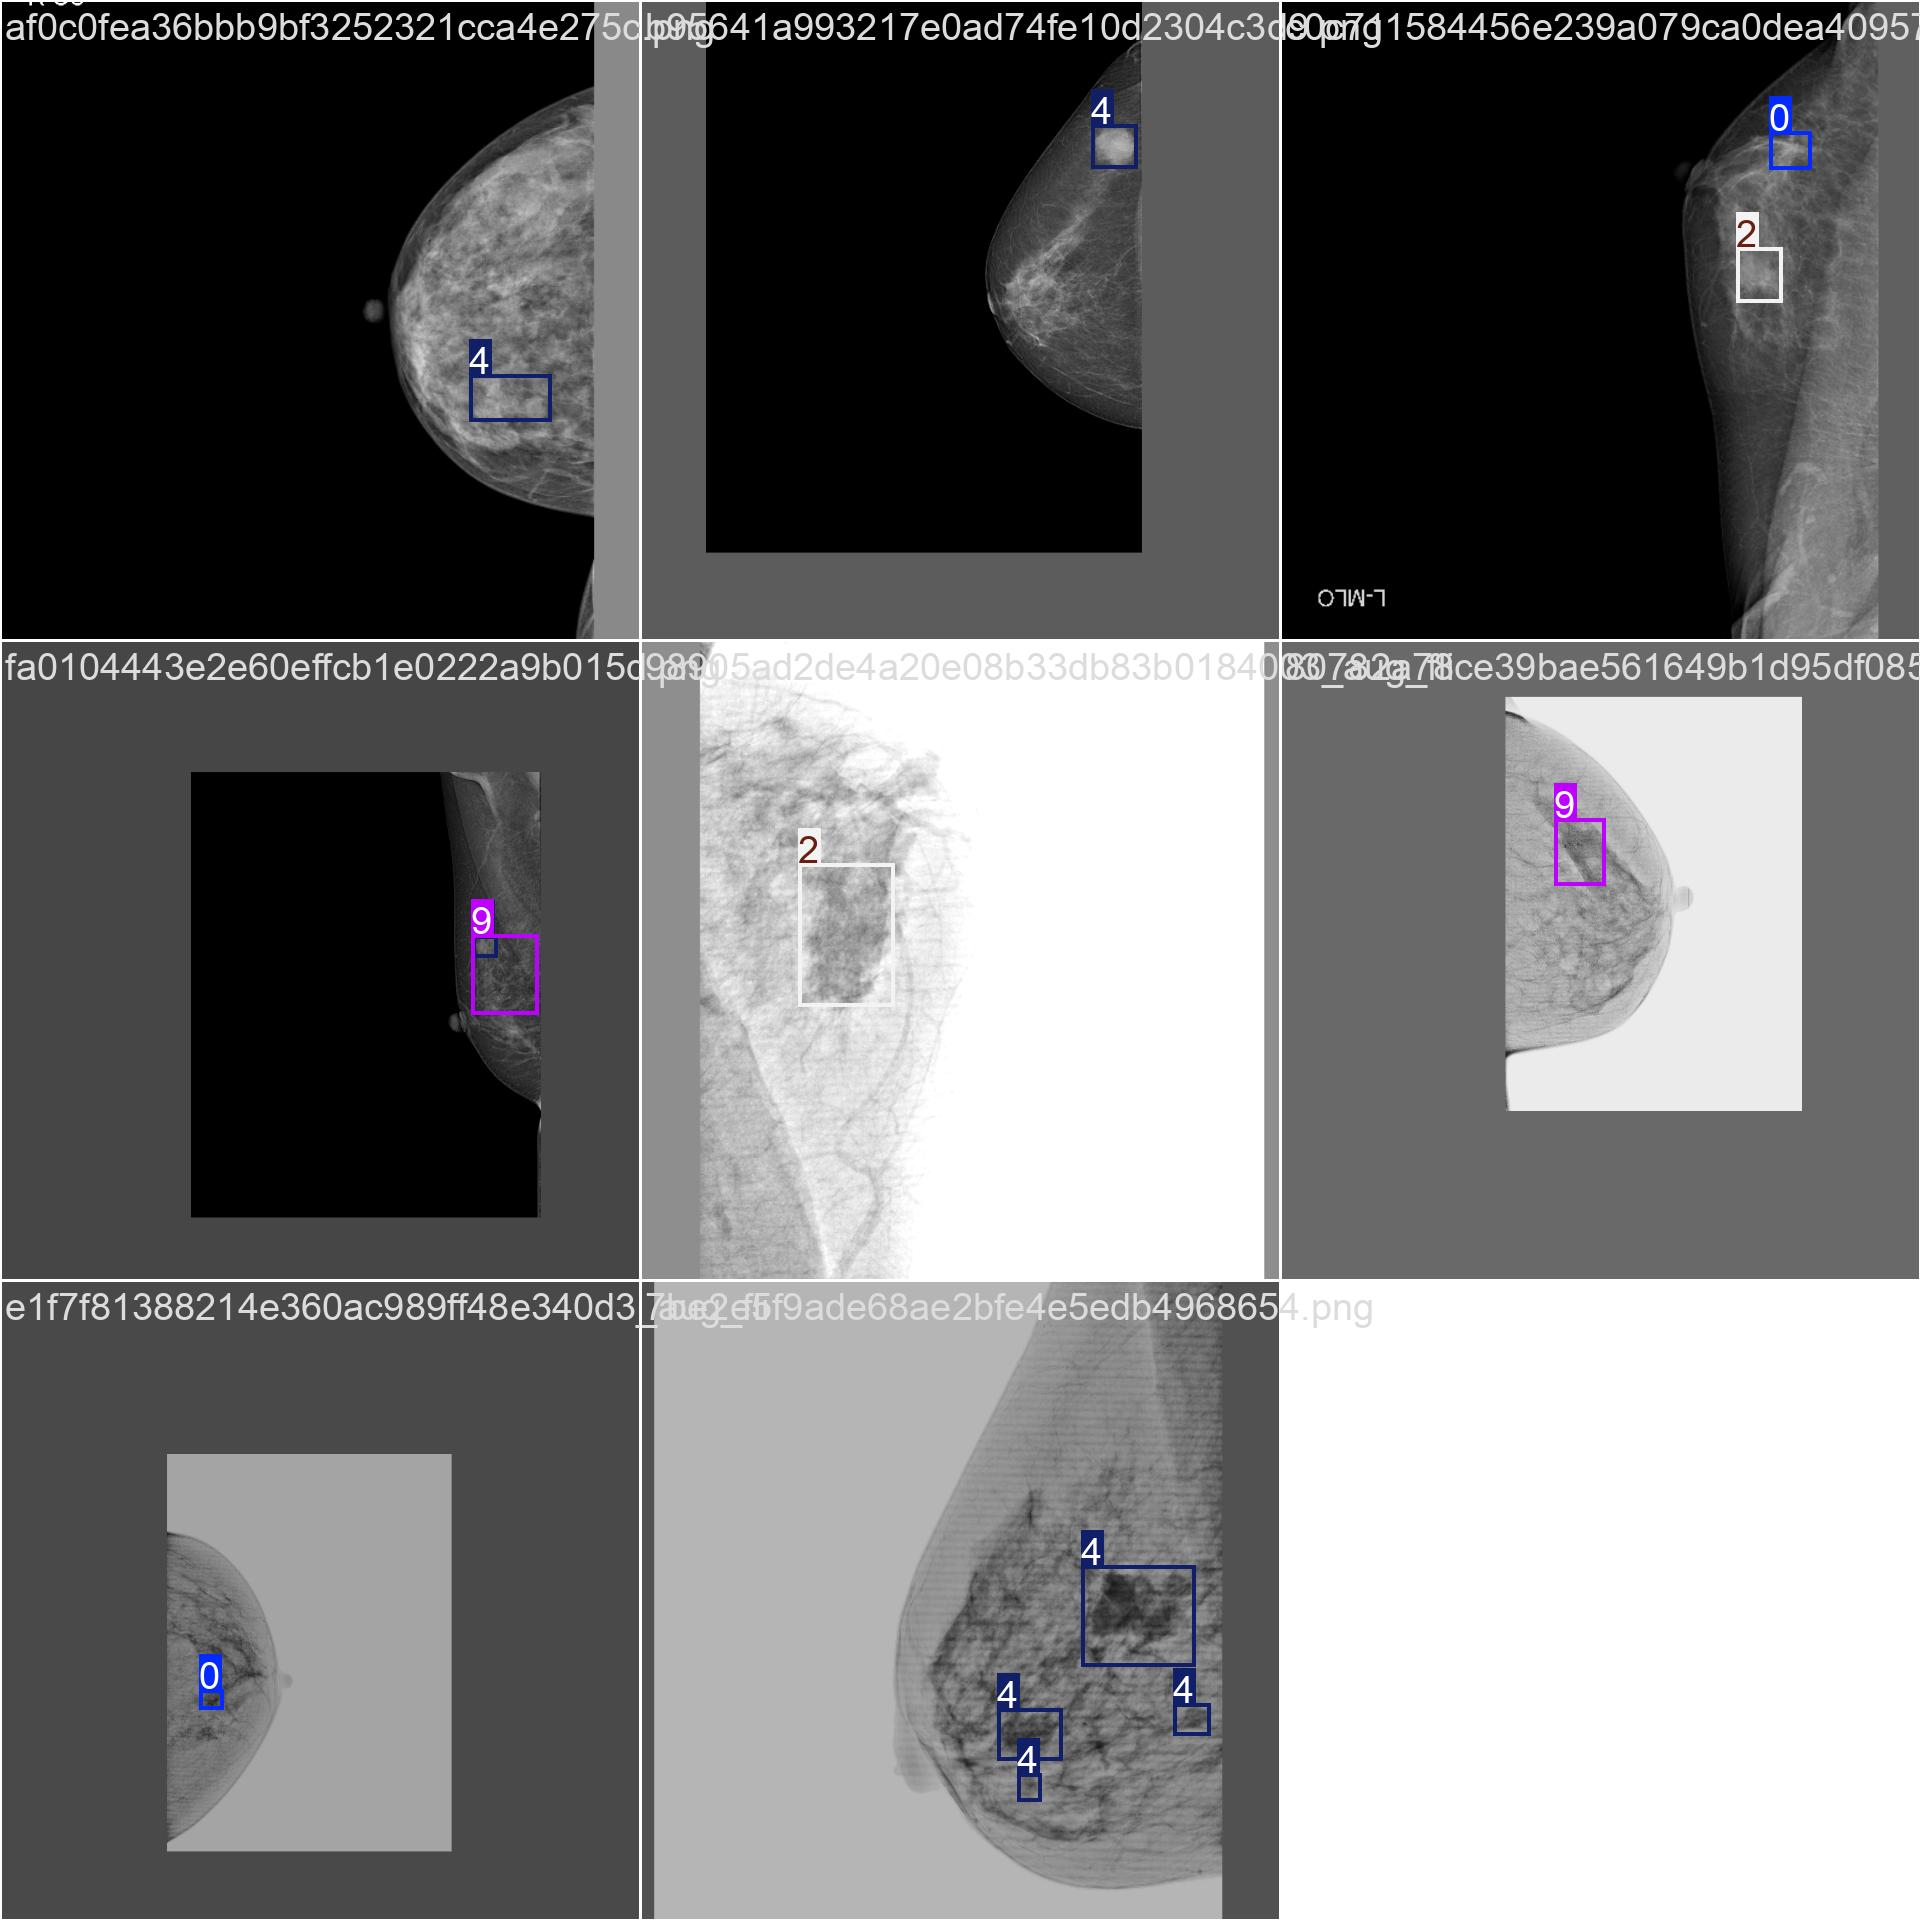
    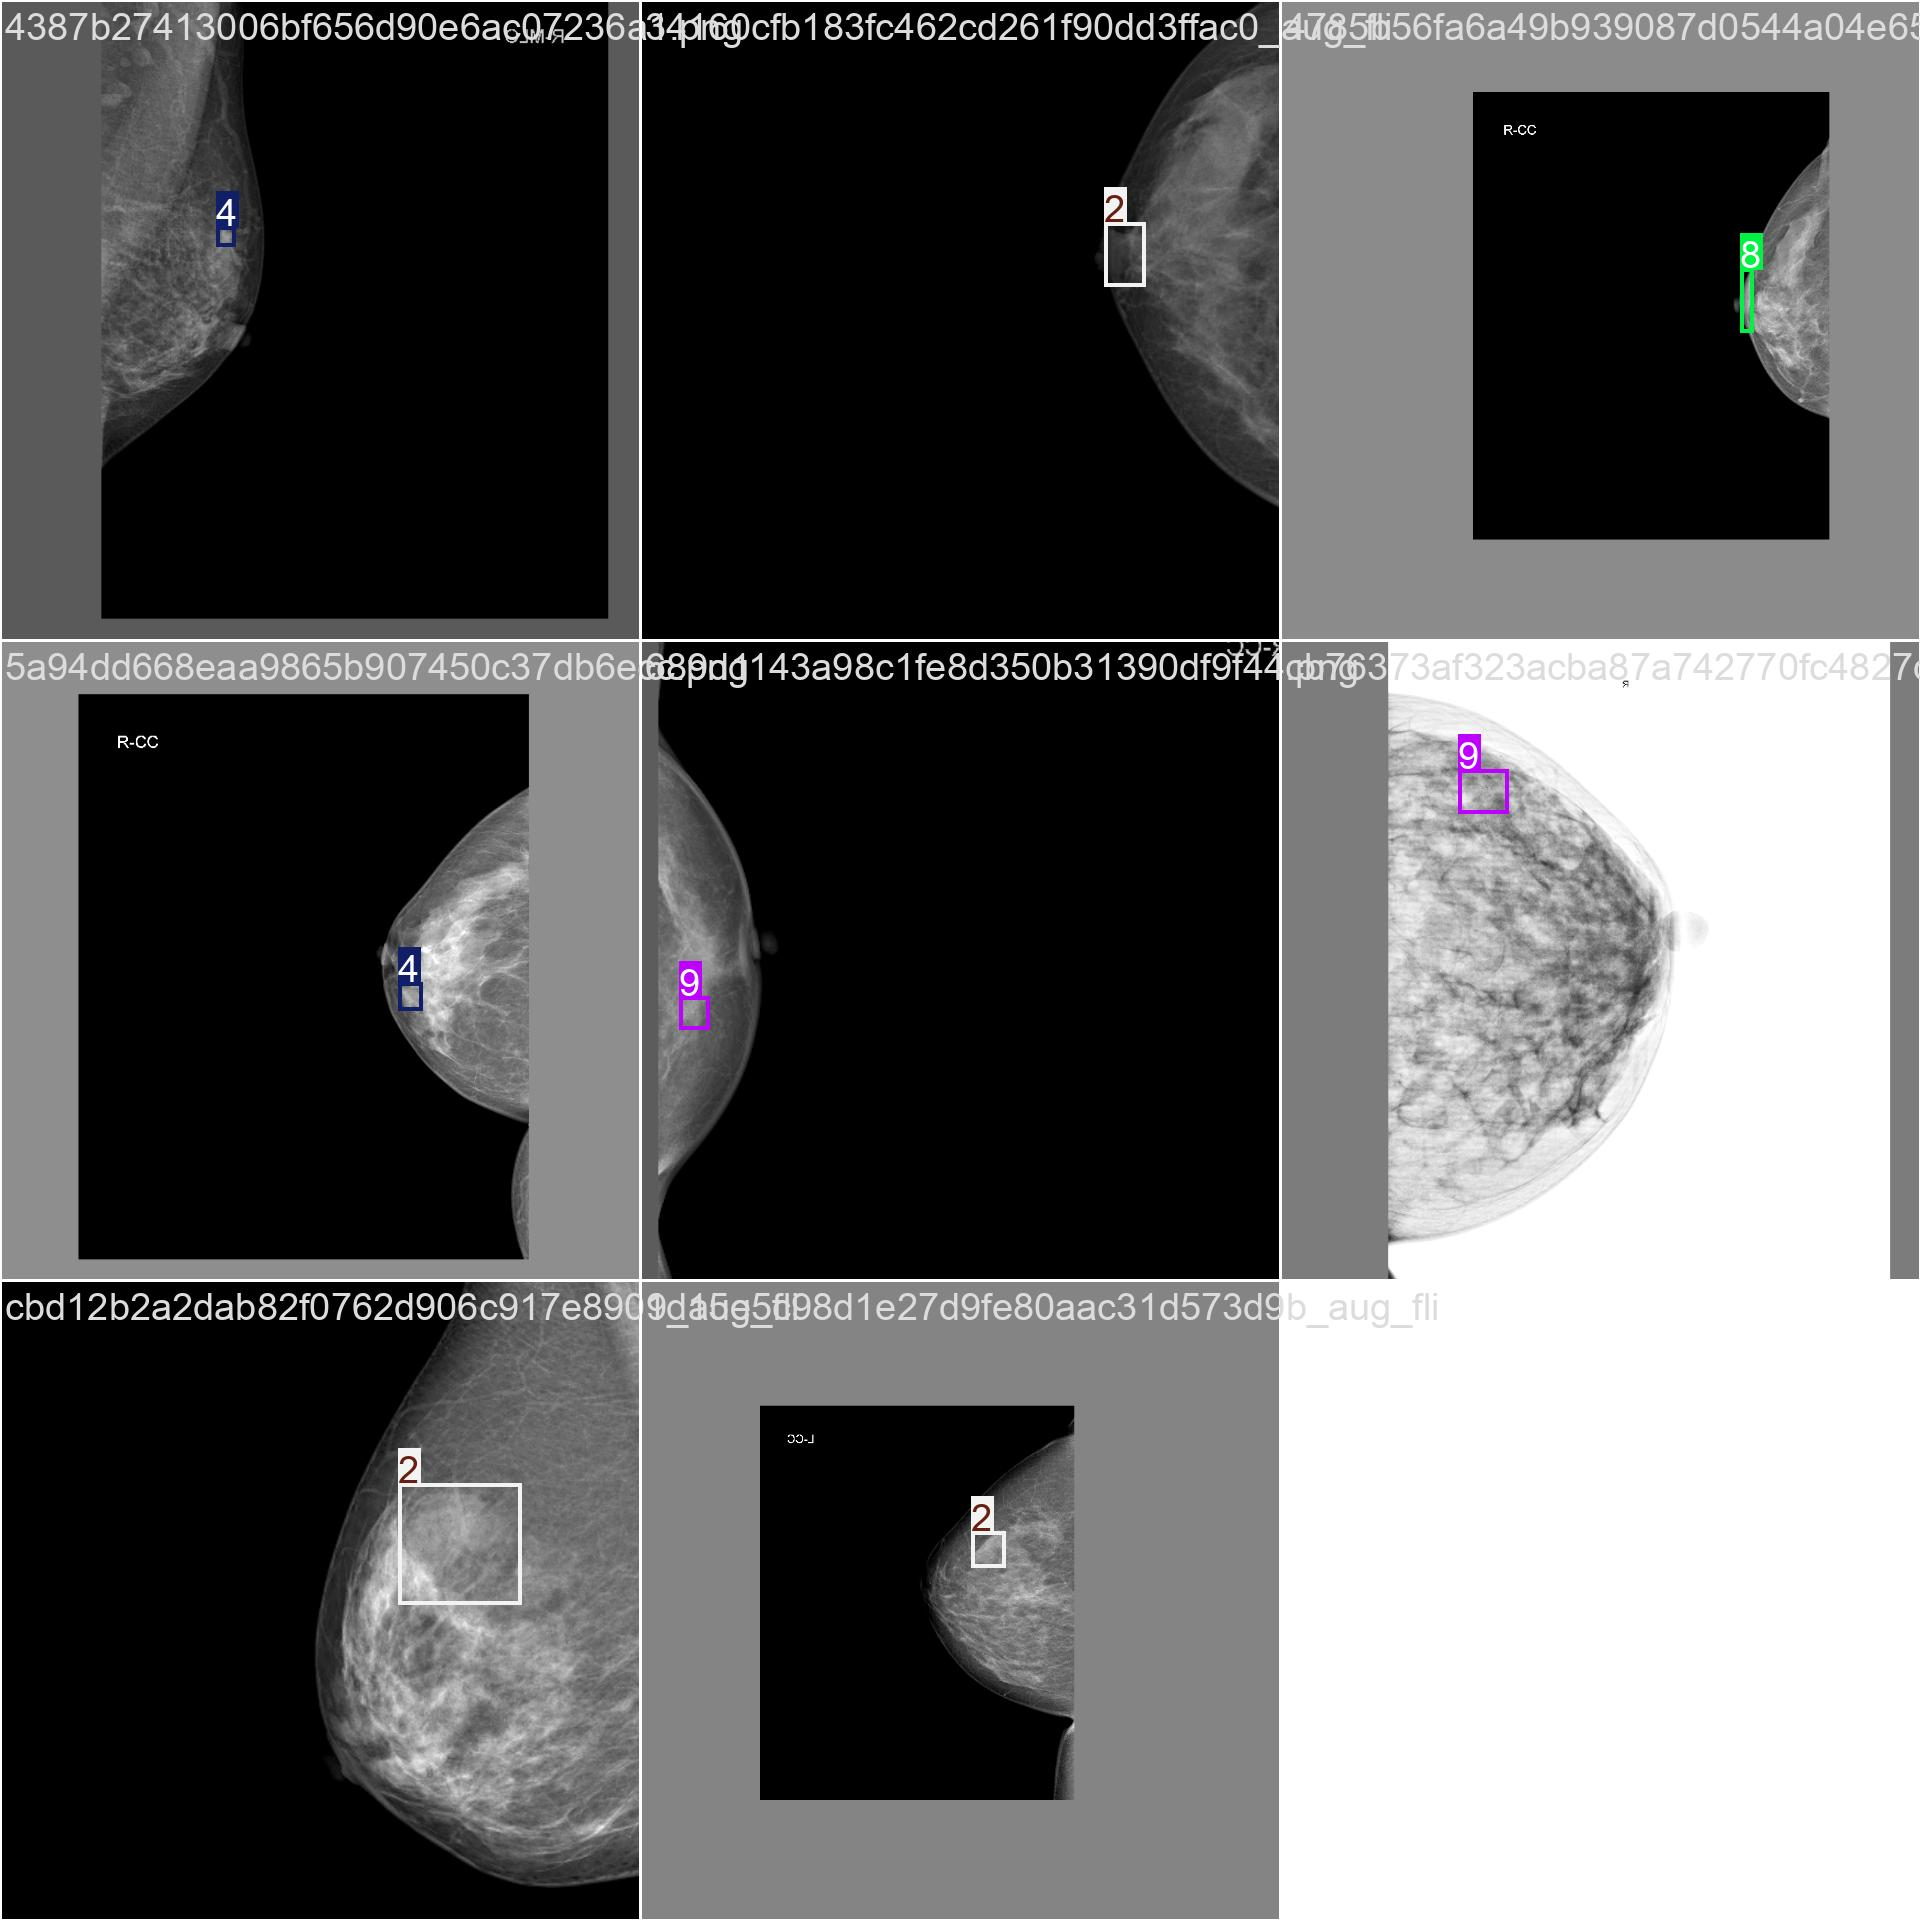
</div>

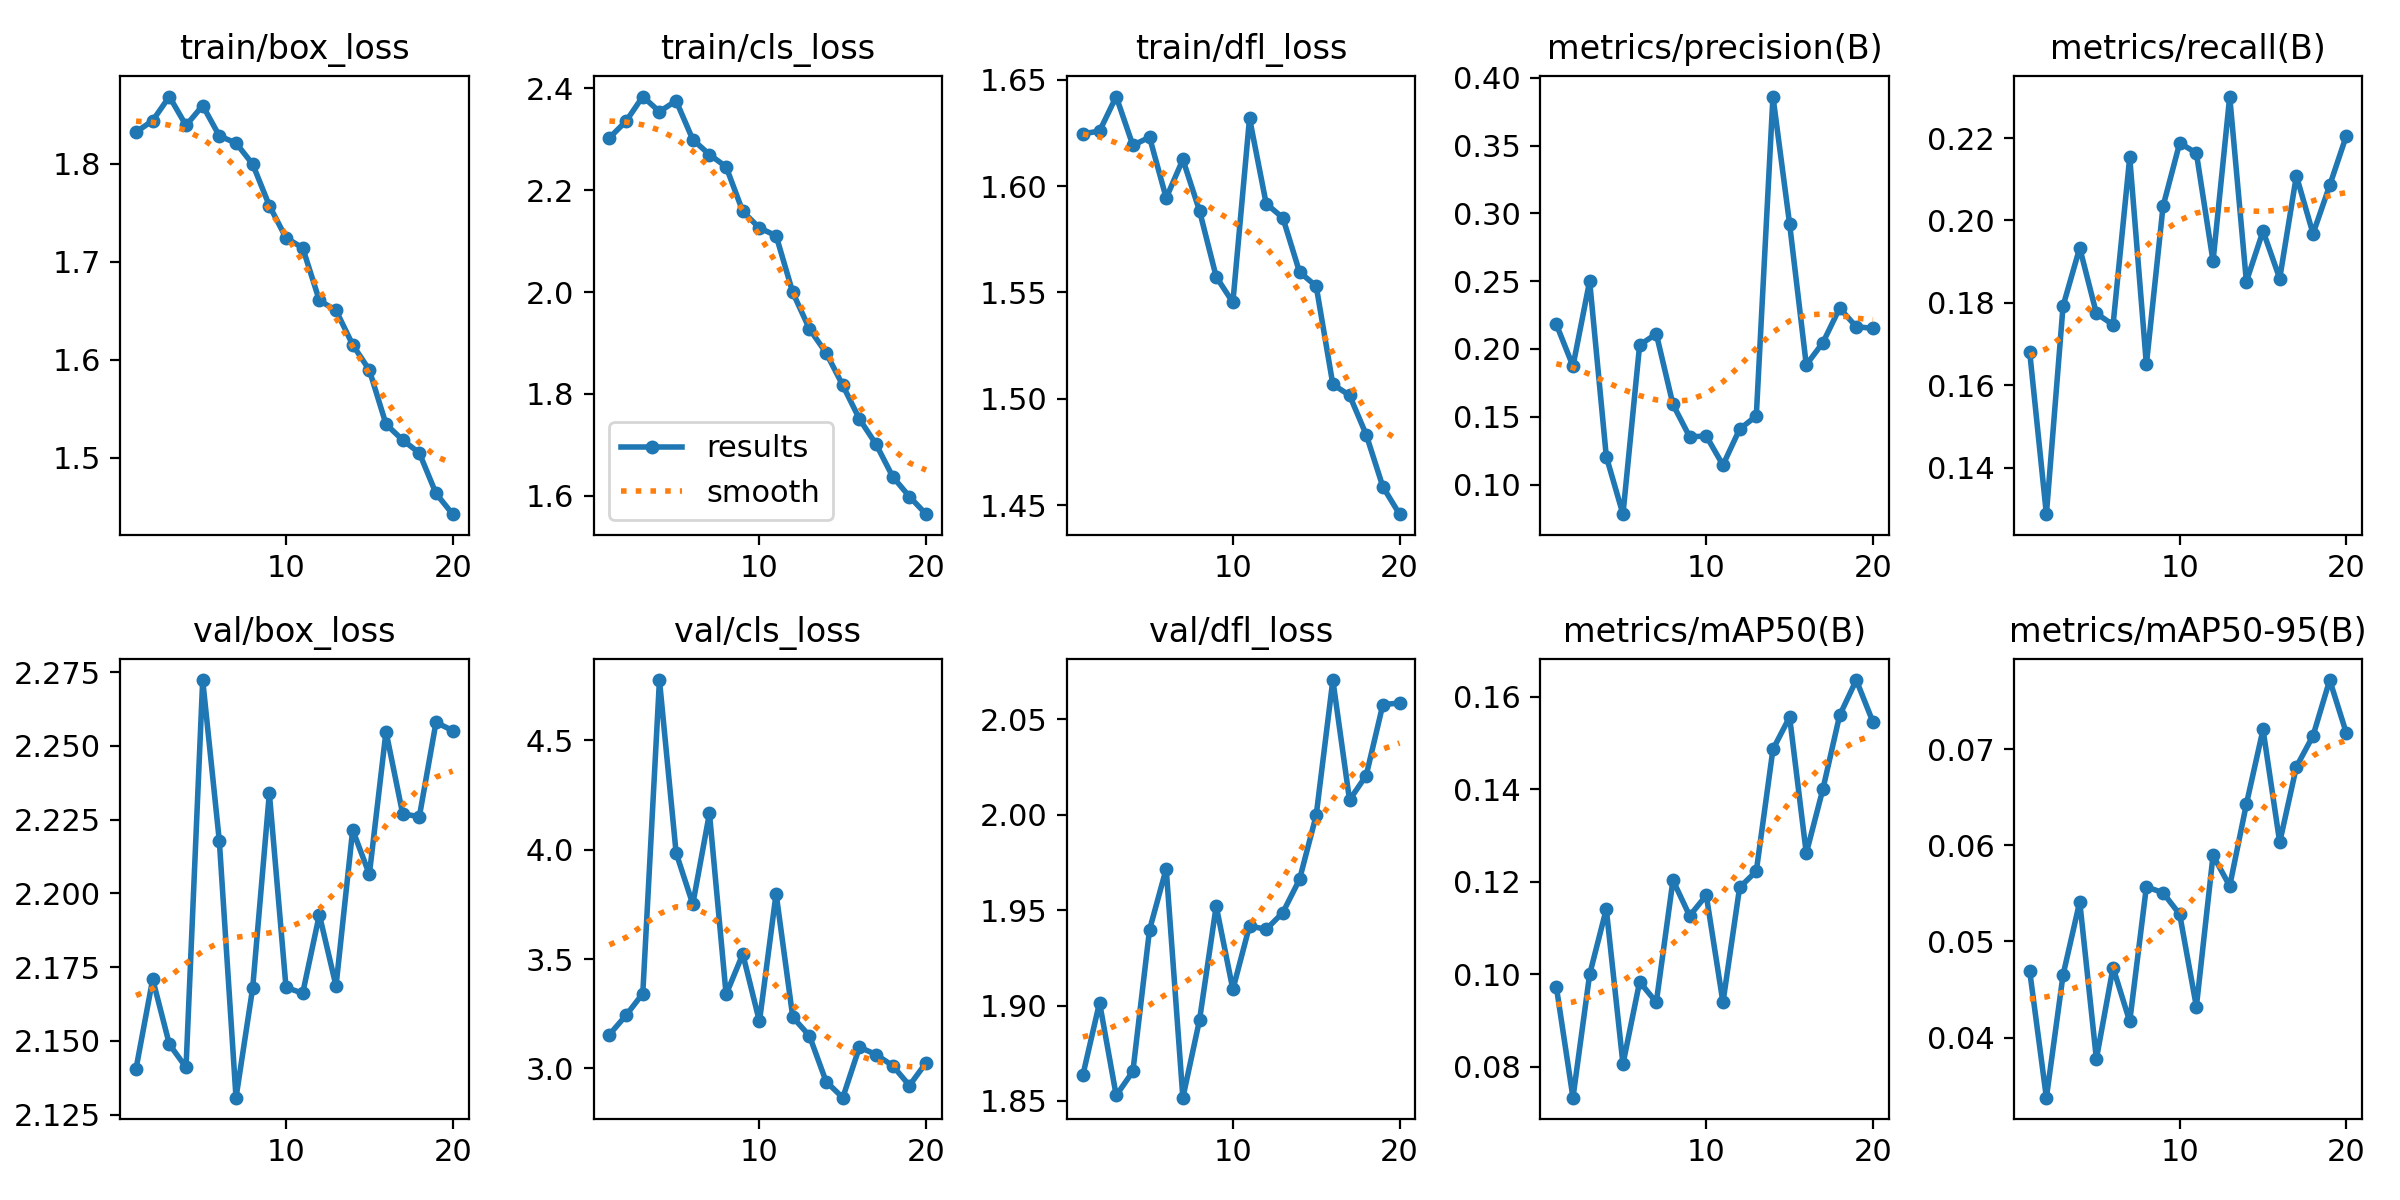

### 7.2 Modelin Görmediği Görüntülerde Testi

<div style="display: flex; justify-content: space-around; align-items: center;">
    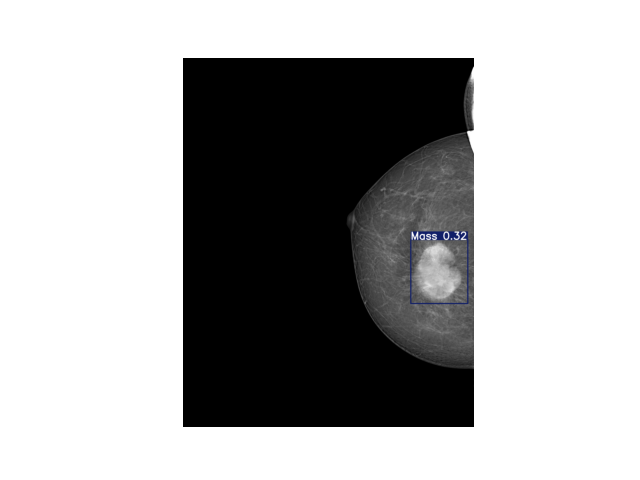
    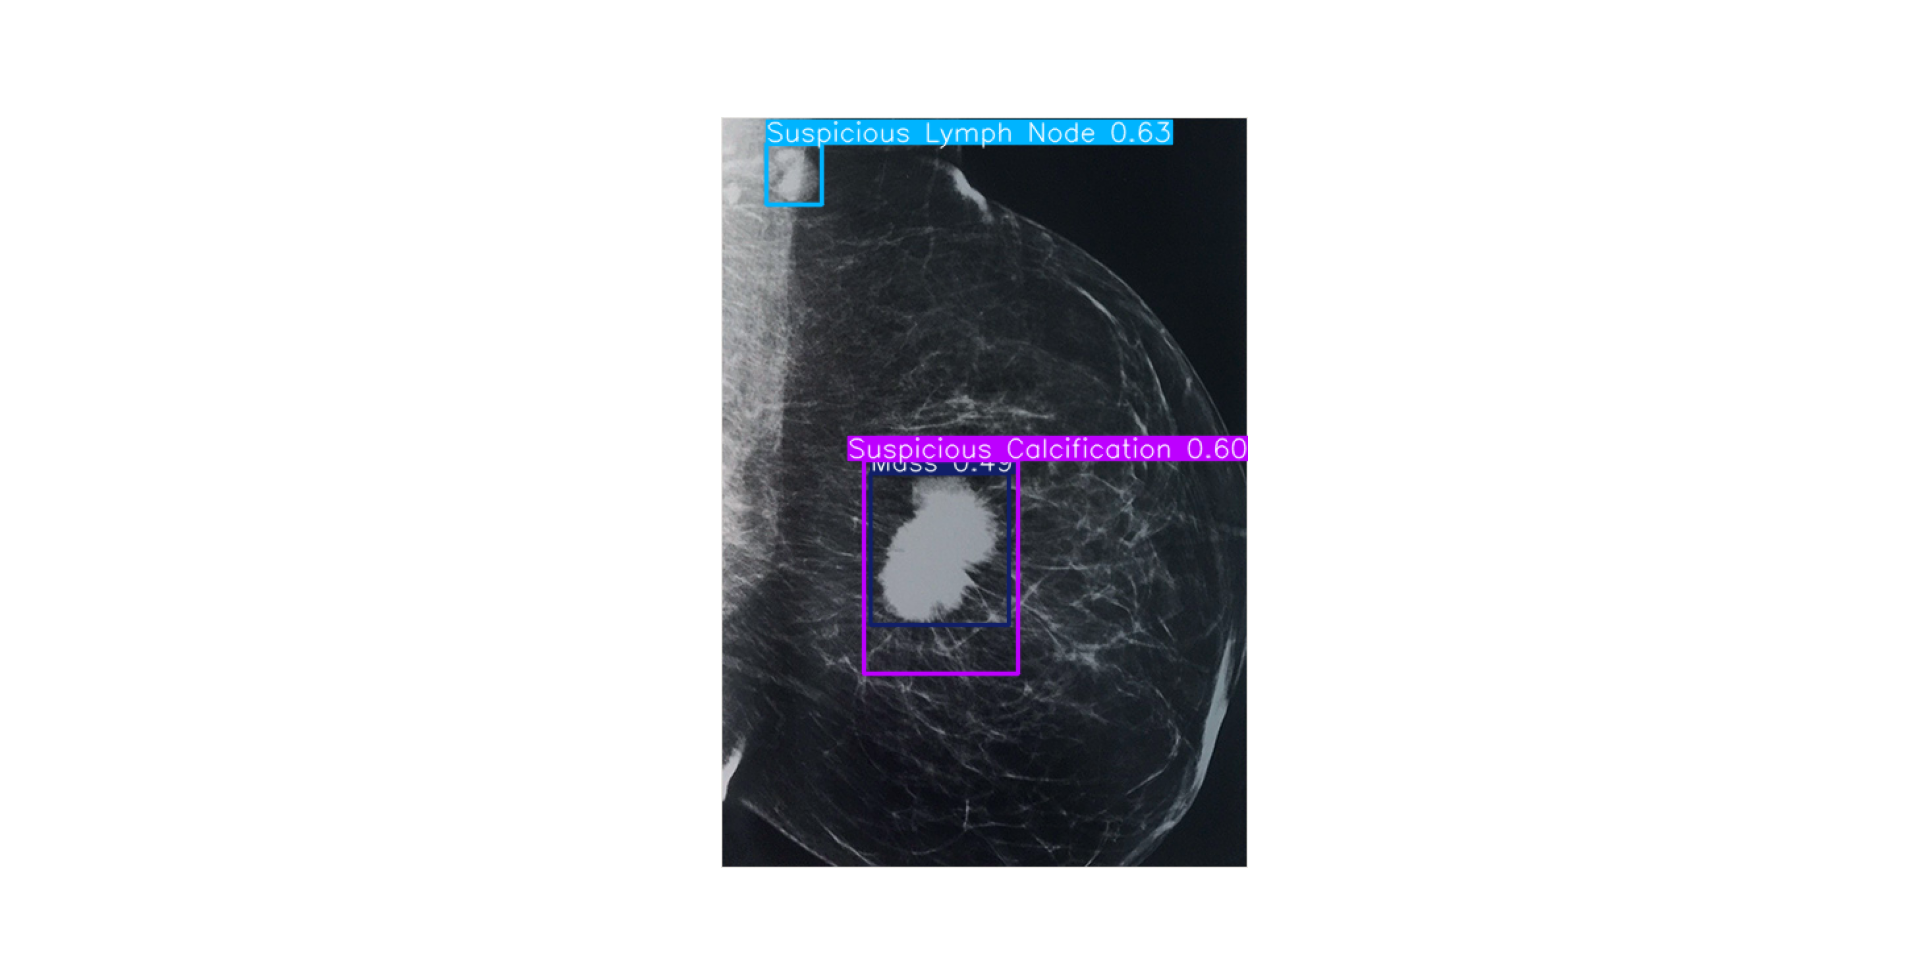
</div>


#### GENEL SONUÇ:

* İlk başta eğitilen YOLOv11-Large  modeli en son eğitilen YOLOv11-Medium modelinden daha iyi sonuç vermiştir.
* Bunun sebepleri olarak veri sayısını çoğaltırken sınıflar arasındaki veri sayısı dengesinin kurulamaması , colab erişim sınırı yüzünden epoch sayısının az verilmesi olduğu düşünülmektedir.
* Daha dengeli bir veri seti oluşturulduğunda ve modelin doyuma ulaştığı bir eğitimde sonucun daha iyi olacağı düşünülmektedir.

# 8. Yalnızca MASS(KİTLE) Sınıfı Kullanılarak Eğitim Yapmak

* Veri sayısı en fazla olan sınıf için YOLOv11-Medium modeliyle 180 epochluk bir eğitim yapılmıştır.(Colab erişim sınırını aşmamak için veri setini küçük aldım tek sınıflık bir eğitim yaptım ve fazla epoch sayısı girebildim.)
* Train  → 894 , Validation → 219 görüntüden oluşmaktadır.


<div style="display: flex; justify-content: space-around; align-items: center;">
    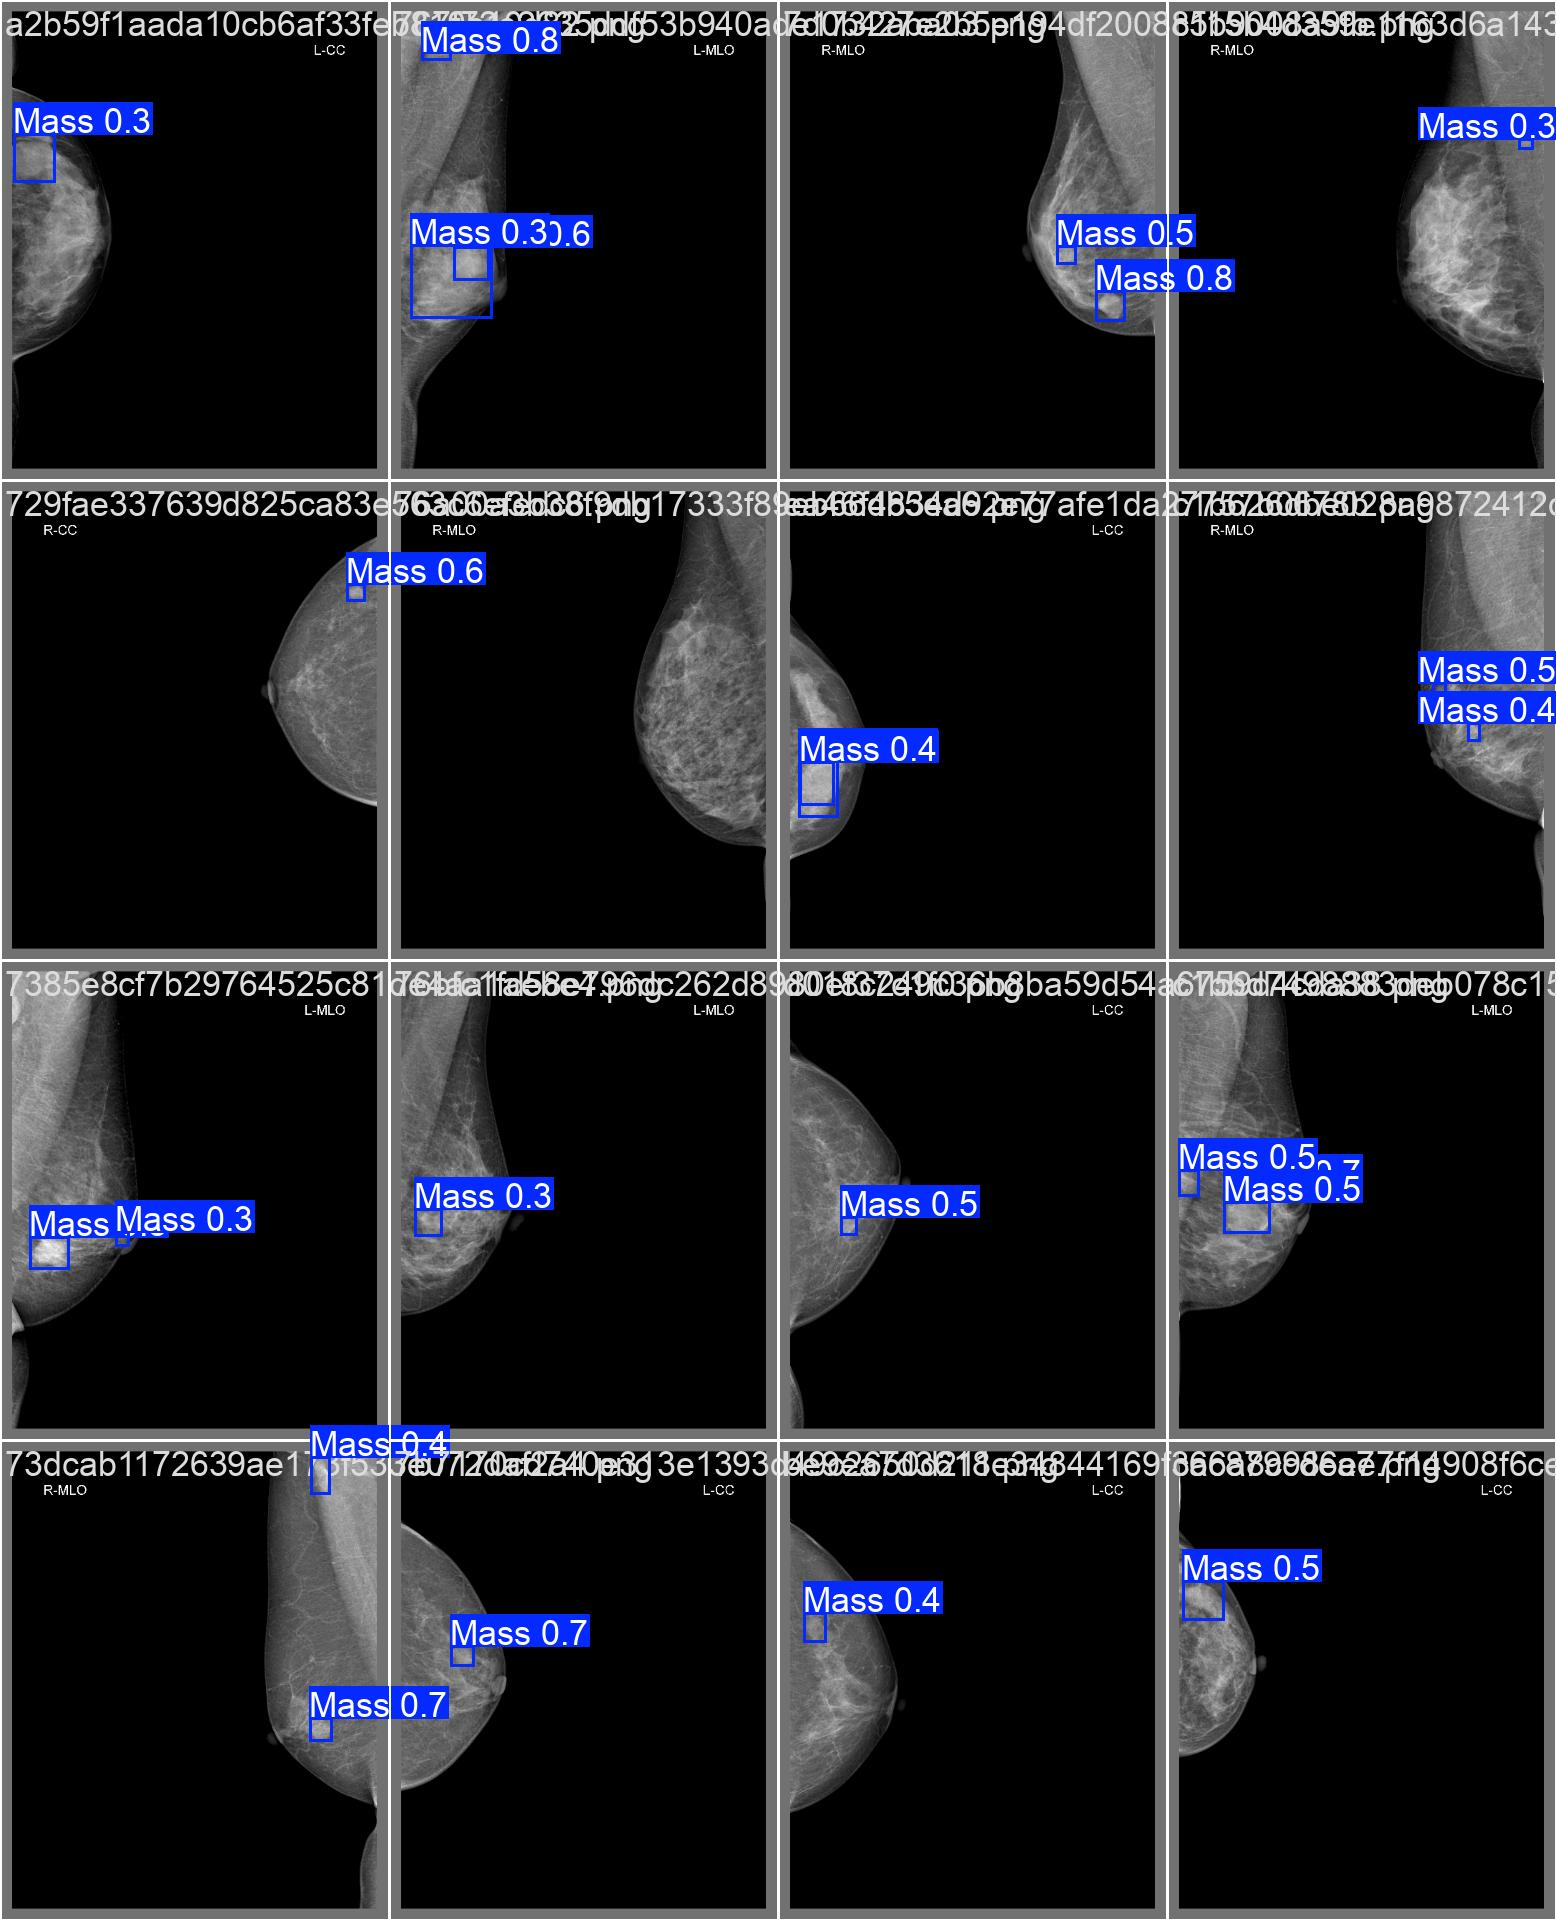
    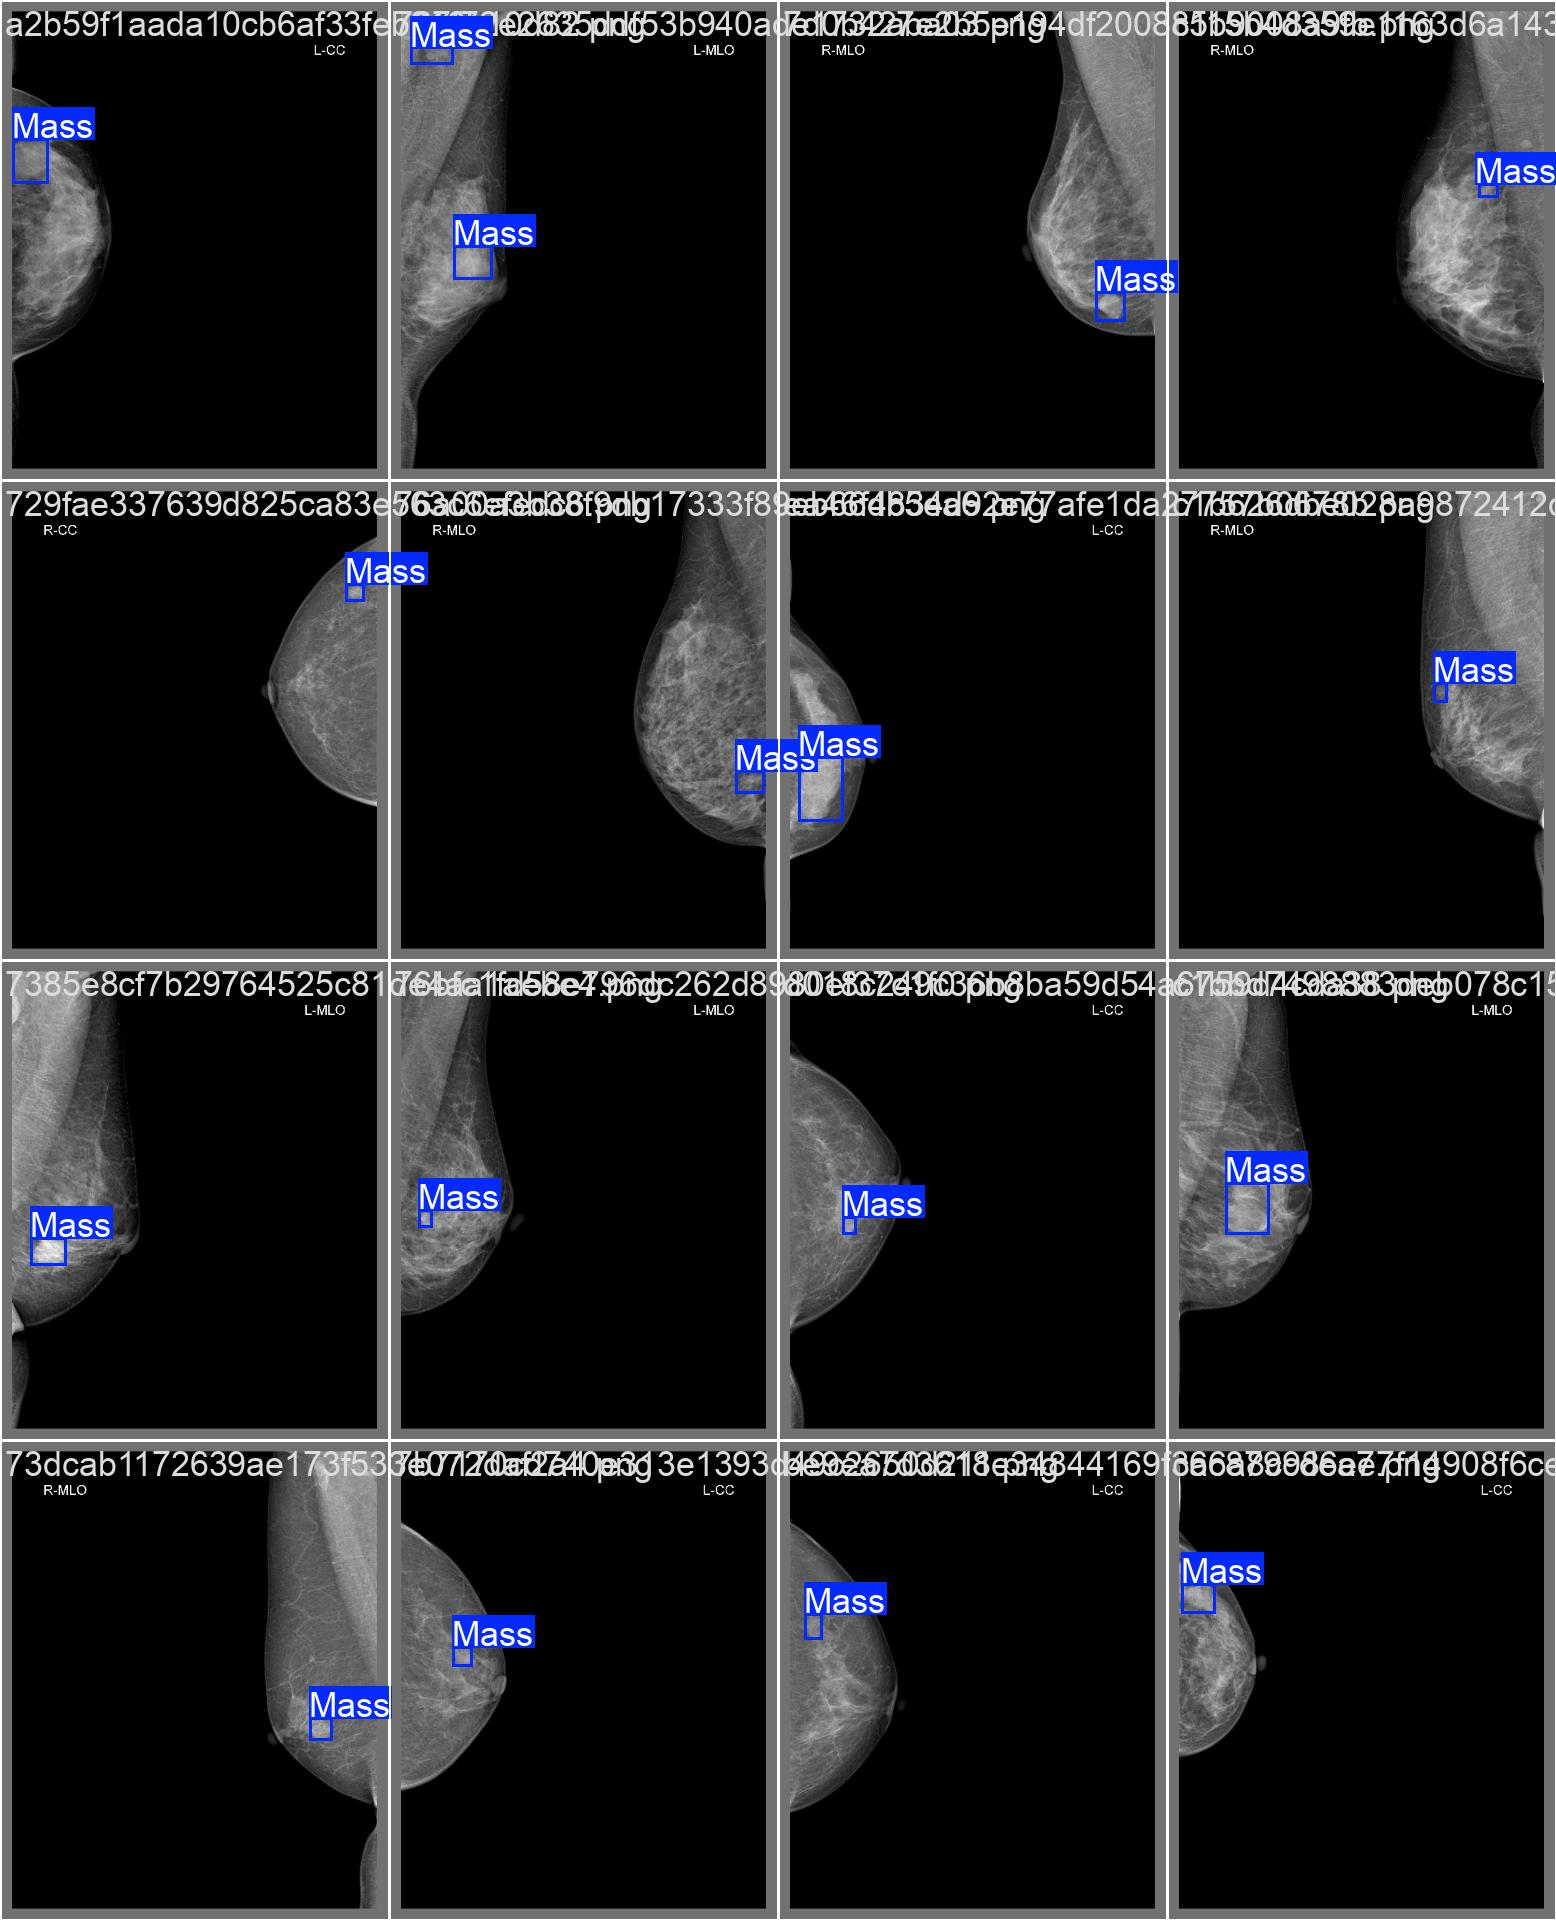
</div>

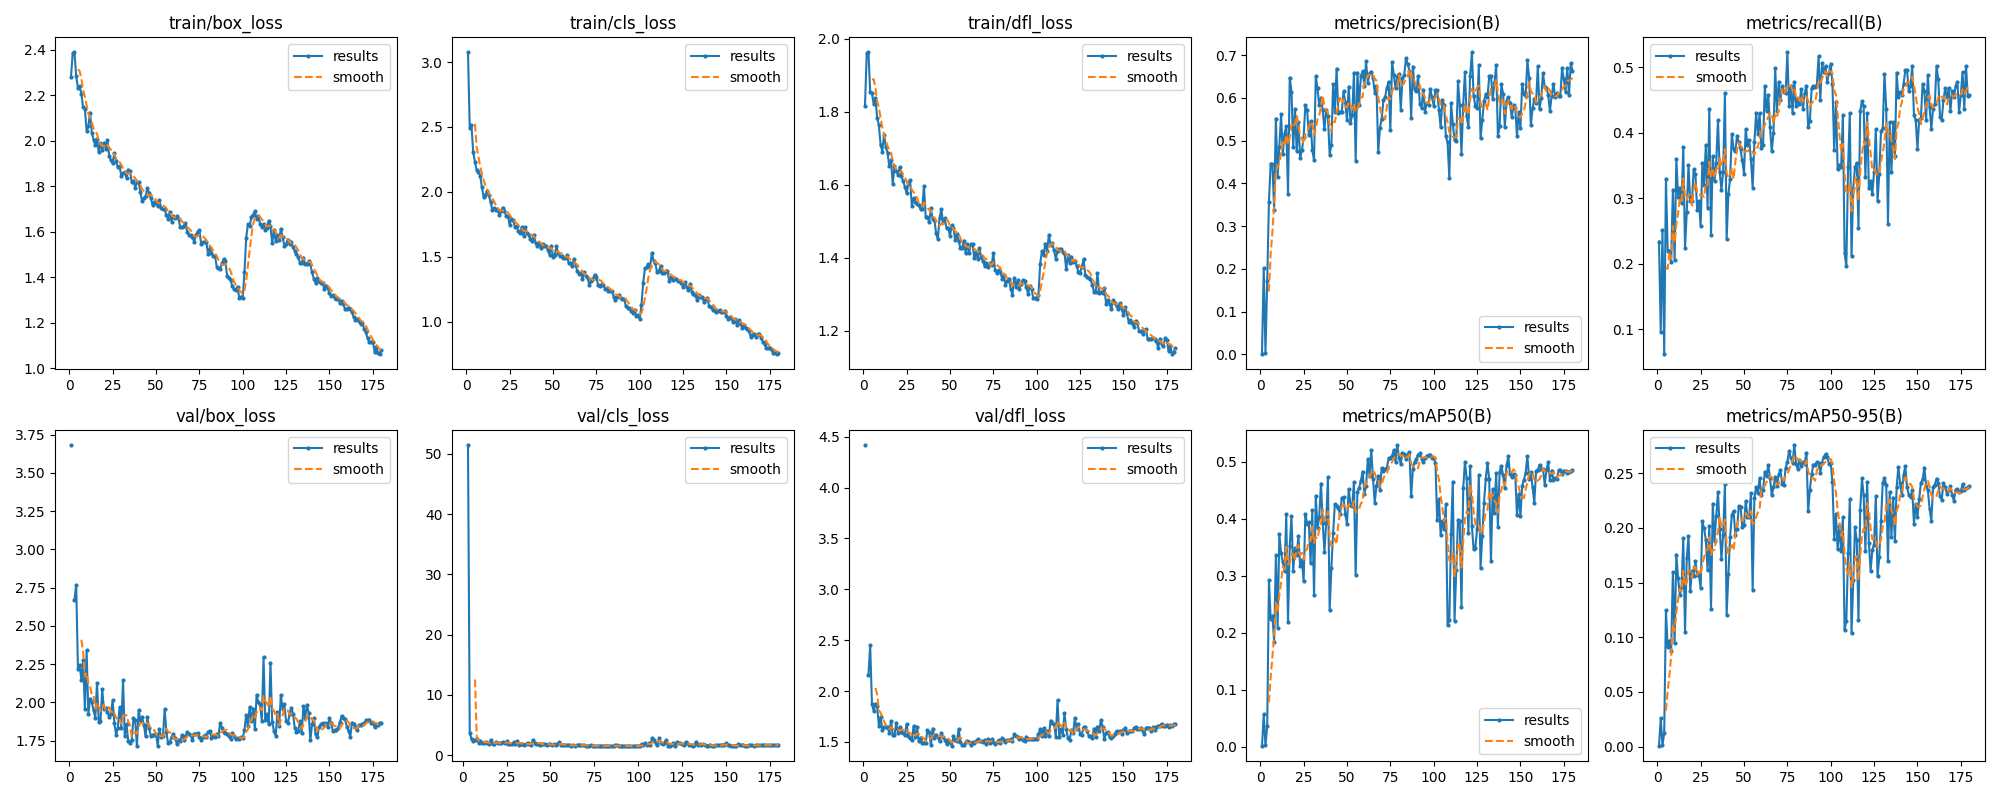

#### Not: Train/cls_loss ve Train/box_loss grafiklerinde 100 epoch'tan sonraki anlık artış , 100 epoch'tan sonra 80 epoch'luk fine-tuning yapıldığı içindir.

#### ÇIKARILAN SONUÇ
* Eğitim için dengeli sınıflar olmalı , eğitimin doyuma ulaşması için daha yüksek epochluk eğitimler yapılmalı.
* Bu sayede daha iyi ve dengeli bir eğitim yapılabileceği öngörülmüştür.

## 8.1 Modelin Test Edilmesi

<div style="display: flex; justify-content: space-around; align-items: center;">
    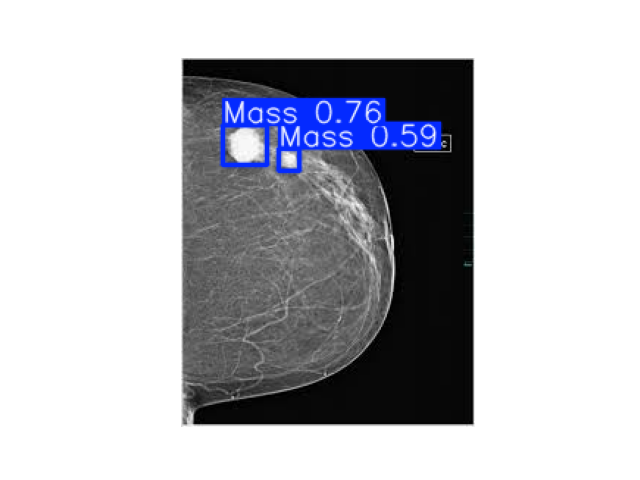
    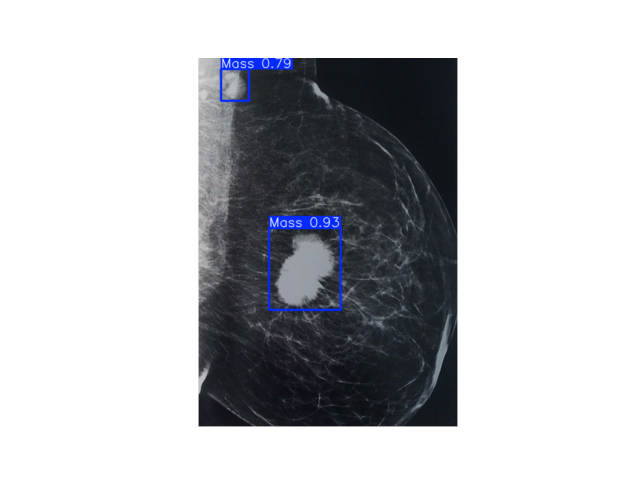
</div>
